In [25]:
# Import main DataFrames from the data folder
import matplotlib.pyplot as plt
import pandas as pd

imported_dfs = {}
for name in ["final_trkData", "tcqData", "notifCount", "MWctr", "preQDat", "postQDat"]:
    imported_dfs[name] = pd.read_csv(f"data/{name}.csv", index_col=0)
    print(f"Imported {name} from data/{name}.csv")

# Optionally, unpack to variables:
final_trkData = imported_dfs["final_trkData"]
tcqData = imported_dfs["tcqData"]
notifCount = imported_dfs["notifCount"]
MWctr = imported_dfs["MWctr"]
preQDat = imported_dfs["preQDat"]
postQDat = imported_dfs["postQDat"]



Imported final_trkData from data/final_trkData.csv
Imported tcqData from data/tcqData.csv
Imported notifCount from data/notifCount.csv
Imported MWctr from data/MWctr.csv
Imported preQDat from data/preQDat.csv
Imported postQDat from data/postQDat.csv


In [26]:

#get the length and colnames
print(f"Shape: {tcqData.shape}")
print(f"Columns: {tcqData.columns.tolist()}")

#but we shoudl subset for the participatns whose mind was actually wandering, so ontask >1
tcqData=tcqData[tcqData['onTask']>1]

#Lets include tempOr for now

tcq_cols = ['visImag', 'inSpeech', 'intent', 'struct', 'real', 'concAbs', 'import', 'relGoal','fullDev', 'oftMind', 'emotVal', 'tempOr']

#drop rows with NaN in any of the tcq_cols
tcqData = tcqData.dropna(subset=tcq_cols)

#Create within and between dataframes
within = tcqData.copy()
within[tcq_cols] = within.groupby("expiwellID")[tcq_cols].transform(lambda x: x - x.mean())

between = tcqData.copy()
between = between.groupby("expiwellID")[tcq_cols].mean()

Shape: (4681, 21)
Columns: ['Start Date', 'End Date', 'Time Scheduled', 'Duration (in seconds)', 'expiwellID', 'Participant ID', 'onTask', 'visImag', 'inSpeech', 'intent', 'struct', 'real', 'concAbs', 'import', 'relGoal', 'fullDev', 'oftMind', 'emotVal', 'tempOr', 'funct', 'functOth']


In [27]:


tcq_cols_analysis = [
    'visImag', 'inSpeech', 'intent', 'struct', 'real', 'concAbs',
    'import', 'relGoal', 'fullDev', 'oftMind', 'emotVal', 'tempOr'
]
# Define new, descriptive row names for plots and tables
tcq_row_names = [
    'Visual', 'Speech', 'Intended', 'Structured', 'Realistic', 'Concrete', 
    'Important', 'Goal', 'Developed', 'Repetitive', 'Affective', 'Temporal'
]
tcq_name_map = dict(zip(tcq_cols_analysis, tcq_row_names))

bsi_score_cols = ['BSI_Somatization','BSI_Obsession','BSI_Interpersonal_Sensitivity','BSI_Depression','BSI_Anxiety',
                  'BSI_Hostility','BSI_Phobic_Anxiety','BSI_Paranoid_Ideation','BSI_Psychoticism','BSI_Global']

iri_cols = [
    'iri_Perspective_Taking', 'iri_Fantasy', 
    'iri_Empathic_Concern', 'iri_Personal_Distress'
]
ipip_cols = [
    'ipip_neo_neuroticism', 'ipip_neo_extraversion', 'ipip_neo_openness',
    'ipip_neo_agreeableness', 'ipip_neo_conscientiousness'
]


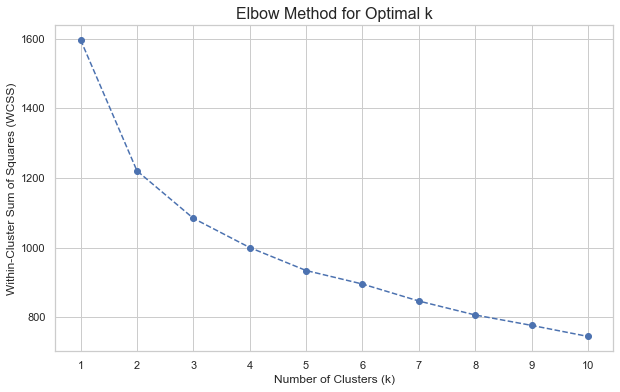


--- Cluster Profiles (n=2) ---
The table below shows the average Z-score for each TCQ factor within each cluster.
A positive value means the cluster's average for that factor is above the overall participant average.
A negative value means it's below the overall average.


,Visual,Speech,Intended,Structured,Realistic,Concrete,Important,Goal,Developed,Repetitive,Affective,Temporal
Cluster,,,,,,,,,,,,
0,0.324,0.196,0.213,0.546,0.375,0.347,0.506,0.520,0.468,0.481,0.356,-0.142
1,-0.489,-0.296,-0.322,-0.824,-0.566,-0.524,-0.763,-0.785,-0.706,-0.727,-0.537,0.214


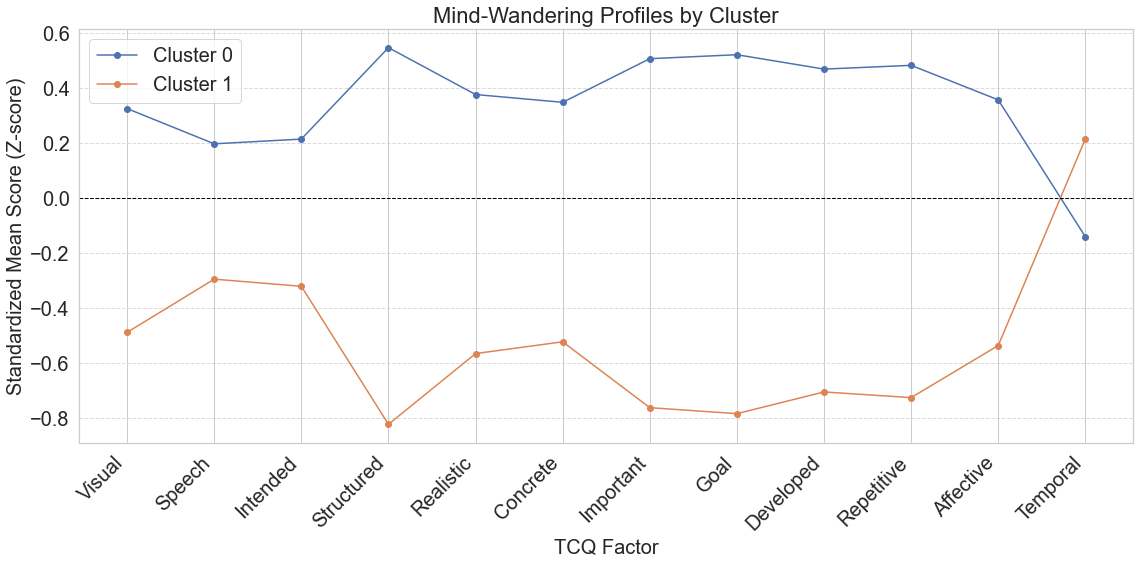

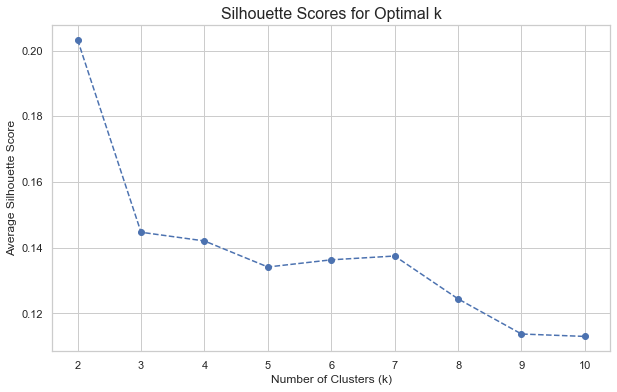

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# --- K-Means Clustering on Between-Participant TCQ Data ---

tcq_cols_analysis = [
    'visImag', 'inSpeech', 'intent', 'struct', 'real', 'concAbs', 
    'import', 'relGoal', 'fullDev', 'oftMind', 'emotVal', 'tempOr'
]

# 1. Prepare the data
# We'll use the 'between' DataFrame which has the mean TCQ scores per participant.
# It's crucial to handle any missing data before clustering.
cluster_data = between[tcq_cols_analysis].dropna()

# Standardize the data: K-means is sensitive to feature scales.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)
scaled_df = pd.DataFrame(scaled_data, index=cluster_data.index, columns=cluster_data.columns)

# 2. Determine the optimal number of clusters using the Elbow Method
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_) # inertia_ is the WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

# --- Run K-Means and Analyze Clusters ---
# Based on the elbow plot, choose an appropriate 'k'. Let's start with k=3 as an example.
# You can change this value based on your interpretation of the elbow plot.
OPTIMAL_K = 2

kmeans = KMeans(n_clusters=OPTIMAL_K, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_df)

# Add the cluster labels back to the original (unscaled) data
between_clustered = cluster_data.copy()
between_clustered['Cluster'] = cluster_labels

# Analyze the cluster centers by calculating the mean of each TCQ factor for each cluster
cluster_profiles = between_clustered.groupby('Cluster')[tcq_cols_analysis].mean()

# To make profiles comparable, let's view the standardized means
scaled_cluster_profiles = scaled_df.copy()
scaled_cluster_profiles['Cluster'] = cluster_labels
scaled_profiles_mean = scaled_cluster_profiles.groupby('Cluster').mean()

print(f"\n--- Cluster Profiles (n={OPTIMAL_K}) ---")
print("The table below shows the average Z-score for each TCQ factor within each cluster.")
print("A positive value means the cluster's average for that factor is above the overall participant average.")
print("A negative value means it's below the overall average.")
display(scaled_profiles_mean.rename(columns=tcq_name_map).round(3))



# 3. Visualize the Cluster Profiles with a Snake Plot
plt.figure(figsize=(16, 8))
for i in range(OPTIMAL_K):
    plt.plot(scaled_profiles_mean.columns, scaled_profiles_mean.loc[i], marker='o', label=f'Cluster {i}')

plt.title('Mind-Wandering Profiles by Cluster', fontsize=22)
plt.ylabel('Standardized Mean Score (Z-score)', fontsize=20)
plt.xlabel('TCQ Factor', fontsize=20)
plt.xticks(ticks=scaled_profiles_mean.columns, labels=scaled_profiles_mean.rename(columns=tcq_name_map).columns, rotation=45, ha='right', fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(0, color='black', linestyle='--', lw=1) # Add a line for the overall average
plt.legend(fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# --- Calculate Silhouette Scores for Different K Values ---
from sklearn.metrics import silhouette_score

silhouette_scores = []
# We start the range from 2 because silhouette score is not defined for k=1
k_range_silhouette = range(2, 11) 

for k in k_range_silhouette:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range_silhouette, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Average Silhouette Score', fontsize=12)
plt.xticks(k_range_silhouette)
plt.grid(True)
plt.show()


==================== K-Means on Within-Participant Data (Episode Level) ====================
This analysis clusters individual thought episodes based on their within-person centered characteristics.

Clustering 2202 individual thought episodes.


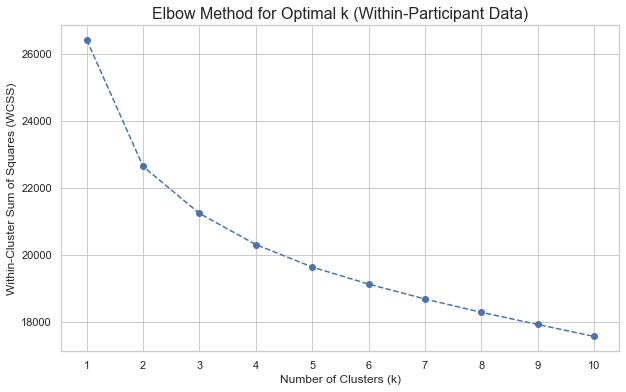


--- Within-Episode Cluster Profiles (n=2) ---
The table shows the average Z-score for each TCQ factor within each episode cluster.


,Visual,Speech,Intended,Structured,Realistic,Concrete,Important,Goal,Developed,Repetitive,Affective,Temporal
Cluster,,,,,,,,,,,,
0,0.110,0.232,0.300,0.366,0.503,0.468,0.498,0.430,0.485,0.276,0.279,0.028
1,-0.119,-0.251,-0.325,-0.396,-0.545,-0.506,-0.540,-0.466,-0.526,-0.299,-0.302,-0.030


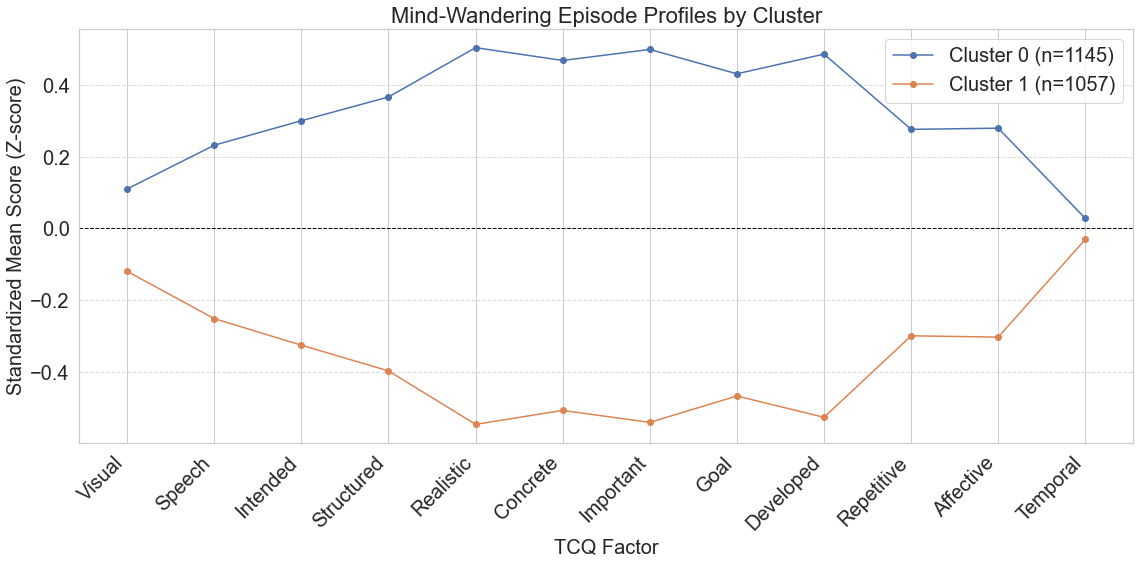

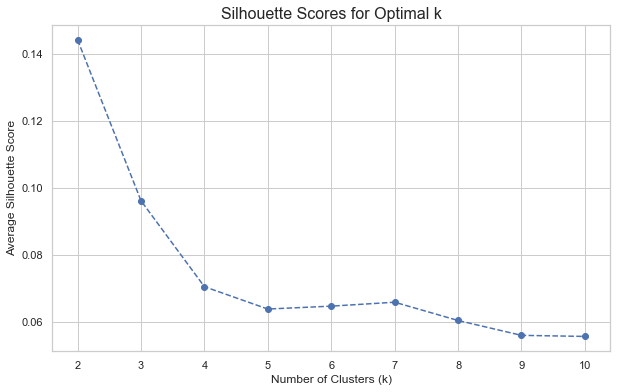

In [29]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# --- K-Means Clustering on Within-Participant TCQ Data (Episode Level) ---

print("\n" + "="*20 + " K-Means on Within-Participant Data (Episode Level) " + "="*20)
print("This analysis clusters individual thought episodes based on their within-person centered characteristics.")


tcq_cols_analysis = [
    'visImag', 'inSpeech', 'intent', 'struct', 'real', 'concAbs', 
    'import', 'relGoal', 'fullDev', 'oftMind', 'emotVal', 'tempOr'
]

# 1. Prepare the data
# We'll use the 'within' DataFrame which has the mean-centered TCQ scores for each episode.
within_cluster_data = within[tcq_cols_analysis].dropna()
print(f"\nClustering {within_cluster_data.shape[0]} individual thought episodes.")

# Standardize the data: K-means is sensitive to feature scales.
within_scaler = StandardScaler()
within_scaled_data = within_scaler.fit_transform(within_cluster_data)
within_scaled_df = pd.DataFrame(within_scaled_data, index=within_cluster_data.index, columns=within_cluster_data.columns)

# 2. Determine the optimal number of clusters using the Elbow Method
wcss_within = []
k_range_within = range(1, 11)
for k in k_range_within:
    kmeans_within = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans_within.fit(within_scaled_df)
    wcss_within.append(kmeans_within.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range_within, wcss_within, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (Within-Participant Data)', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.xticks(k_range_within)
plt.grid(True)
plt.show()

# --- Run K-Means and Analyze Clusters ---
# Based on the elbow plot, choose an appropriate 'k'. Let's use k=3 as an example.
OPTIMAL_K_WITHIN = 2

kmeans_within = KMeans(n_clusters=OPTIMAL_K_WITHIN, init='k-means++', random_state=42, n_init=10)
within_cluster_labels = kmeans_within.fit_predict(within_scaled_df)

# Add the cluster labels back to the data
within_scaled_df['Cluster'] = within_cluster_labels

# Analyze the cluster centers (profiles)
within_cluster_profiles = within_scaled_df.groupby('Cluster').mean()

print(f"\n--- Within-Episode Cluster Profiles (n={OPTIMAL_K_WITHIN}) ---")
print("The table shows the average Z-score for each TCQ factor within each episode cluster.")
display(within_cluster_profiles.rename(columns=tcq_name_map).round(3))

# 3. Visualize the Cluster Profiles with a Snake Plot
plt.figure(figsize=(16, 8))
for i in range(OPTIMAL_K_WITHIN):
    cluster_size = (within_scaled_df['Cluster'] == i).sum()
    plt.plot(within_cluster_profiles.columns, within_cluster_profiles.loc[i], marker='o', label=f'Cluster {i} (n={cluster_size})')

plt.title('Mind-Wandering Episode Profiles by Cluster', fontsize=22)
plt.ylabel('Standardized Mean Score (Z-score)', fontsize=20)
plt.xlabel('TCQ Factor', fontsize=20)
plt.xticks(ticks=within_cluster_profiles.columns, labels=within_cluster_profiles.rename(columns=tcq_name_map).columns, rotation=45, ha='right', fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.legend(fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Calculate Silhouette Scores for Different K Values ---
from sklearn.metrics import silhouette_score

silhouette_scores = []
# We start the range from 2 because silhouette score is not defined for k=1
k_range_silhouette = range(2, 11) 

for k in k_range_silhouette:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(within_scaled_df)
    score = silhouette_score(within_scaled_df, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range_silhouette, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Average Silhouette Score', fontsize=12)
plt.xticks(k_range_silhouette)
plt.grid(True)
plt.show()


==================== Distribution of Episode Clusters Across Participants ====================

--- Summary of Cluster Proportions Across Participants ---
This table shows the average percentage of each episode type per person.


Cluster,Cluster 0,Cluster 1
count,13300.0,13300.0
mean,54.7,45.3
std,13.7,13.7
min,20.0,0.0
25%,46.7,40.0
50%,52.6,47.4
75%,60.0,53.3
max,100.0,80.0


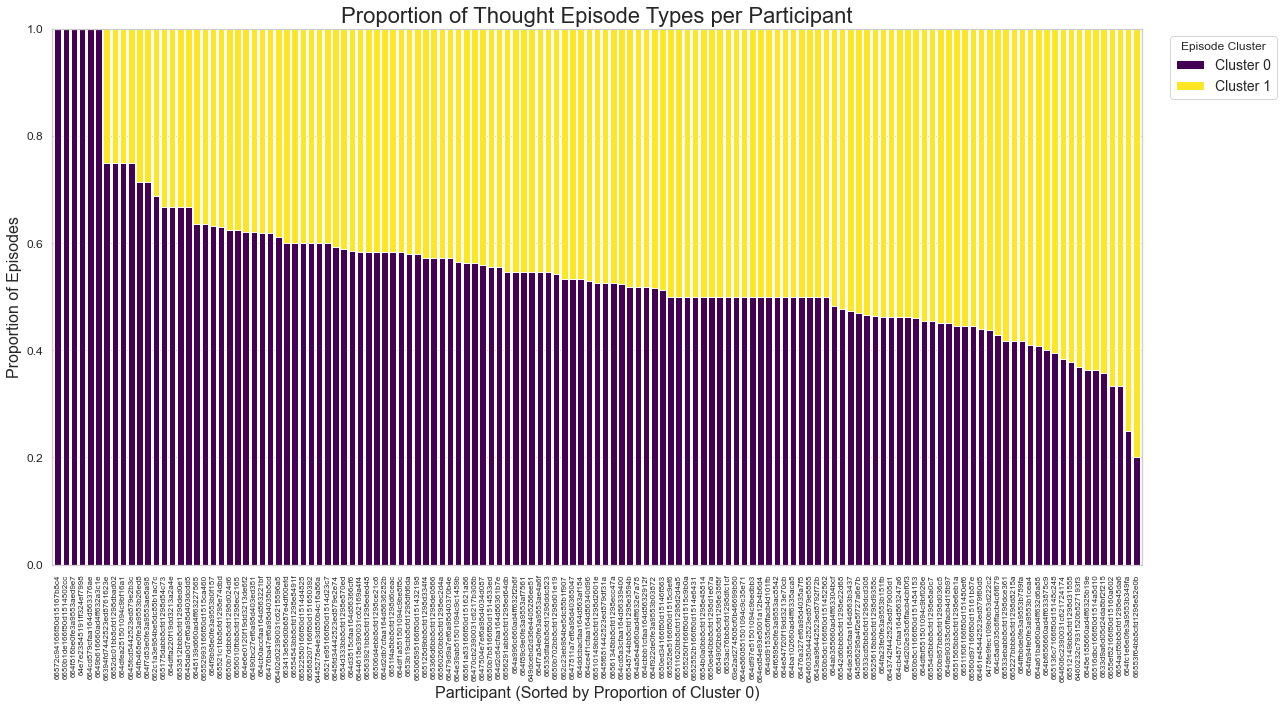

In [30]:


import seaborn as sns

# --- Distribution of Episode Clusters Across Participants ---

print("\n" + "="*20 + " Distribution of Episode Clusters Across Participants " + "="*20)

# 1. Merge cluster labels with participant IDs
# The 'within_scaled_df' has the cluster labels, and its index matches the 'within' DataFrame.
# We need the 'expiwellID' from the 'within' DataFrame to group by participant.
episodes_with_clusters = within.join(within_scaled_df['Cluster'], how='inner')

# 2. Calculate the proportion of each cluster type for each participant
participant_cluster_dist = episodes_with_clusters.groupby('expiwellID')['Cluster'].value_counts(normalize=True).unstack(fill_value=0)

# Ensure all cluster columns exist, even if a participant has none of a certain type
for i in range(OPTIMAL_K_WITHIN):
    if i not in participant_cluster_dist.columns:
        participant_cluster_dist[i] = 0

# Rename columns for clarity in the plot legend
participant_cluster_dist = participant_cluster_dist.rename(columns={i: f'Cluster {i}' for i in range(OPTIMAL_K_WITHIN)})

# 3. Display summary statistics
print("\n--- Summary of Cluster Proportions Across Participants ---")
print("This table shows the average percentage of each episode type per person.")
display((participant_cluster_dist.describe() * 100).round(1))


# 4. Create a proportional stacked bar chart
# Sort participants by the proportion of one of the clusters for better visualization
# Let's sort by 'Cluster 0' as an example
sorted_proportions = participant_cluster_dist.sort_values(by='Cluster 0', ascending=False)

ax = sorted_proportions.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 10),
    width=0.8,
    cmap='viridis' # Using a different colormap for distinction
)

# 5. Customize the plot
ax.set_title('Proportion of Thought Episode Types per Participant', fontsize=22)
ax.set_xlabel('Participant (Sorted by Proportion of Cluster 0)', fontsize=16)
ax.set_ylabel('Proportion of Episodes', fontsize=16)
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.tick_params(axis='y', labelsize=12)
ax.legend(title='Episode Cluster', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=14)
ax.set_ylim(0, 1) # Proportions sum to 1

plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout for legend
plt.show()

In [31]:

# Count the number of participants in each numerical cluster
cluster_counts = between_clustered['Cluster'].value_counts().sort_index()
print("--- Participants per Numerical Cluster ---")
print(cluster_counts)

# Count the number of participants using the descriptive labels ('Hi', 'Med', 'Lo')
# The 'plot_df' DataFrame was created in the visualization cell
if 'plot_df' in locals():
    labeled_cluster_counts = plot_df['Cluster_Label'].value_counts()
    print("\n--- Participants per Labeled Cluster ---")
    print(labeled_cluster_counts)

--- Participants per Numerical Cluster ---
0    80
1    53
Name: Cluster, dtype: int64

--- Participants per Labeled Cluster ---
Lo    78
Hi    52
Name: Cluster_Label, dtype: int64



==================== Distribution of Between-Participant Clusters ====================
--- Participants per Between-Participant Cluster ---
0    80
1    53
Name: Cluster, dtype: int64


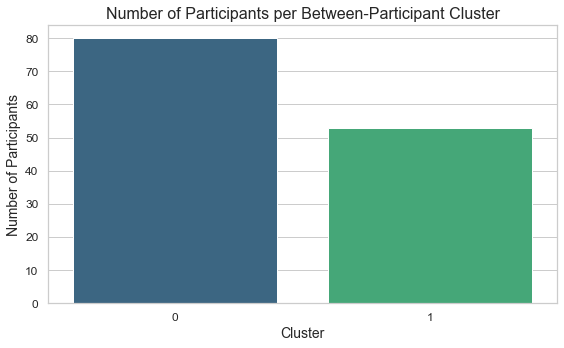

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Distribution of Cluster Assignments Across Participants ---

# BETWEEN-PARTICIPANT CLUSTERS
print("\n" + "="*20 + " Distribution of Between-Participant Clusters " + "="*20)

# 1. Count participants per cluster
between_cluster_counts = between_clustered['Cluster'].value_counts().sort_index()
print("--- Participants per Between-Participant Cluster ---")
print(between_cluster_counts)

# 2. Visualize as a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=between_cluster_counts.index, y=between_cluster_counts.values, palette='viridis')
plt.title('Number of Participants per Between-Participant Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Number of Participants', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


--- BSI Scores by Cluster ---
Mean scores for each BSI dimension across the 3 clusters. Yellow highlight indicates a significant difference (p < 0.05) between clusters.


,0,1,F-statistic,p-value
BSI_Somatization,12.73,10.13,9.35,0.00
BSI_Obsession,14.38,13.10,1.90,0.17
BSI_Interpersonal_Sensitivity,9.05,7.60,5.82,0.02
BSI_Depression,12.83,10.65,6.84,0.01
BSI_Anxiety,12.13,10.46,4.66,0.03
BSI_Hostility,12.17,11.04,6.19,0.01
BSI_Phobic_Anxiety,9.28,7.69,4.77,0.03
BSI_Paranoid_Ideation,10.03,7.73,11.54,0.00
BSI_Psychoticism,9.90,7.83,10.80,0.00
BSI_Global,106.24,88.58,8.77,0.00



--- IRI Scores by Cluster ---
Mean scores for each IRI dimension across the 3 clusters. Yellow highlight indicates a significant difference (p < 0.05) between clusters.


,0,1,F-statistic,p-value
iri_Perspective_Taking,3.31,3.04,8.88,0.00
iri_Fantasy,3.54,3.20,8.39,0.00
iri_Empathic_Concern,4.01,3.62,9.13,0.00
iri_Personal_Distress,3.24,2.79,14.49,0.00



--- IPIP-NEO Scores by Cluster ---
Mean scores for each IPIP-NEO dimension across the 3 clusters. Yellow highlight indicates a significant difference (p < 0.05) between clusters.


,0,1,F-statistic,p-value
ipip_neo_neuroticism,34.95,35.90,0.59,0.45
ipip_neo_extraversion,39.33,35.56,14.14,0.00
ipip_neo_openness,34.77,33.44,3.86,0.05
ipip_neo_agreeableness,39.81,38.65,4.12,0.04
ipip_neo_conscientiousness,34.69,33.63,2.83,0.09


Found 15 variables with significant differences. Generating plots...


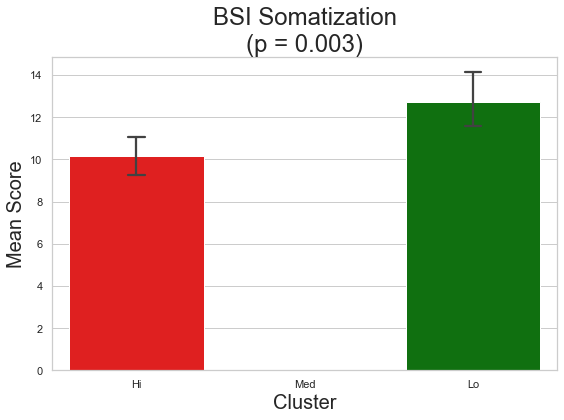

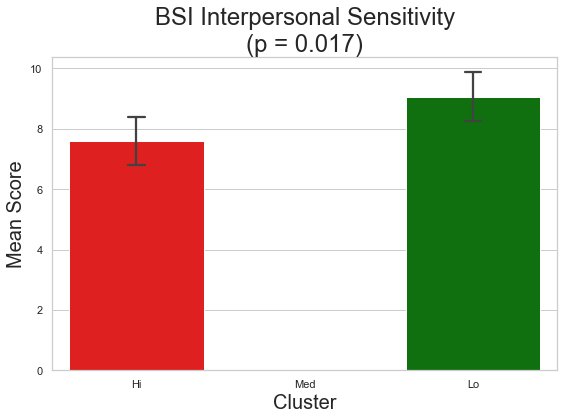

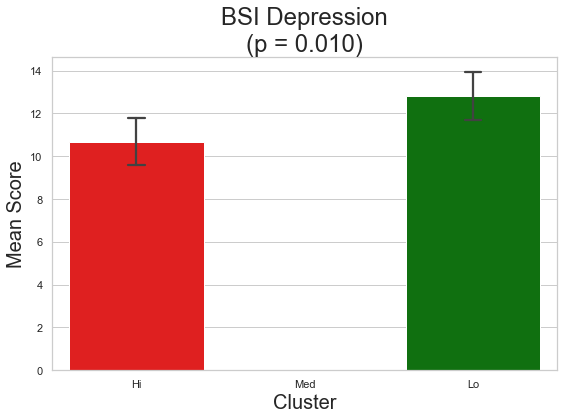

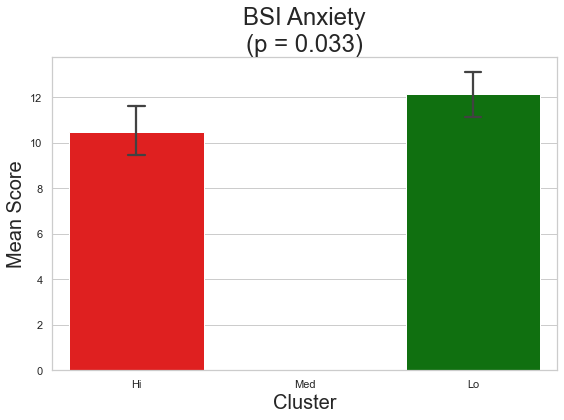

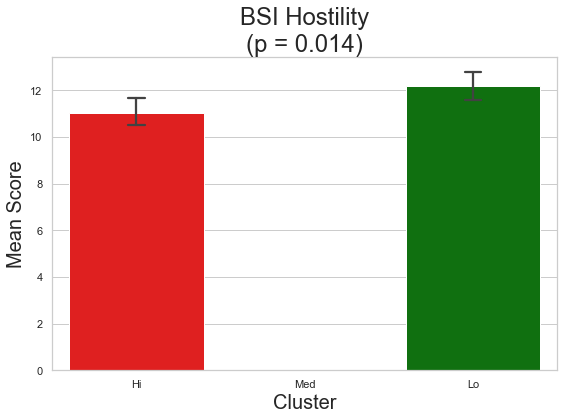

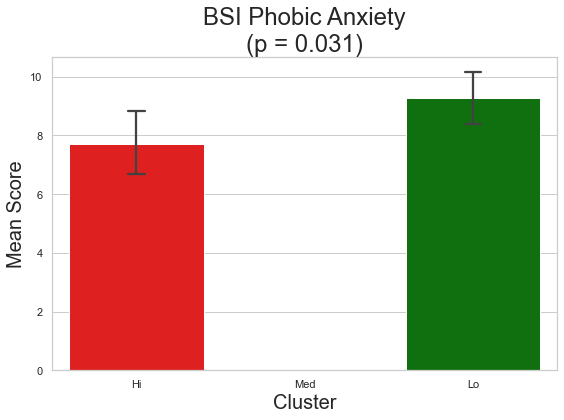

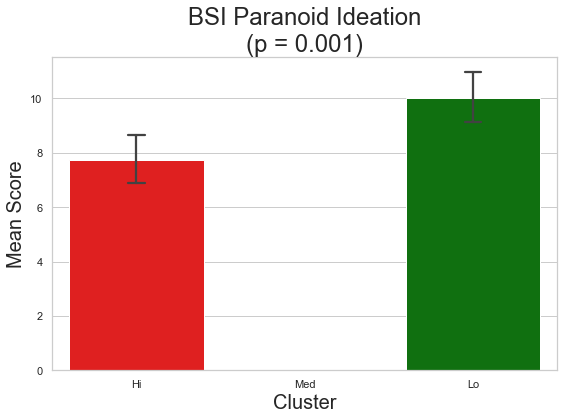

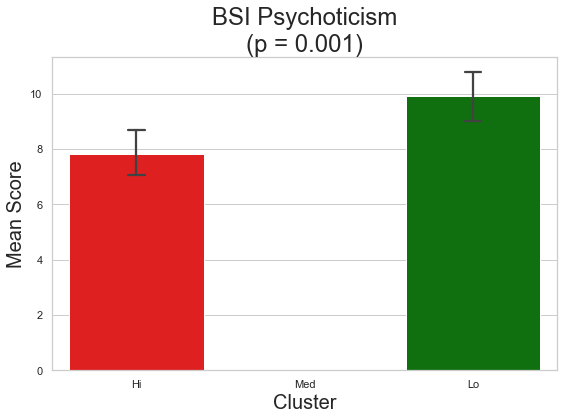

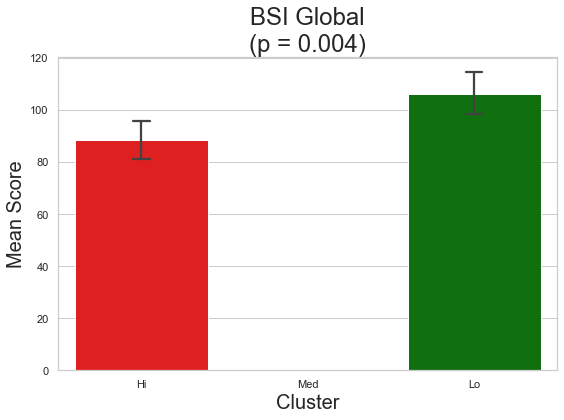

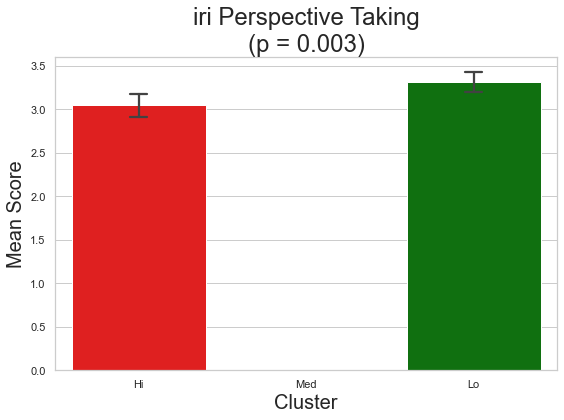

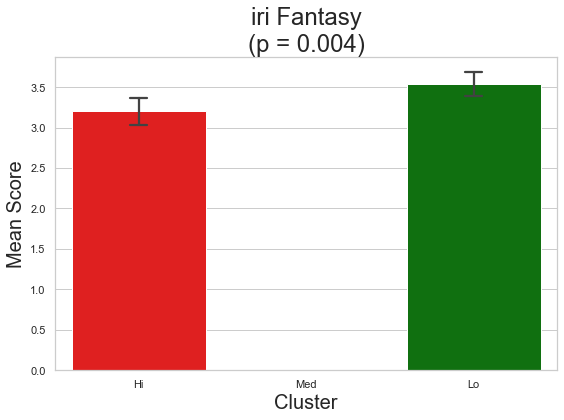

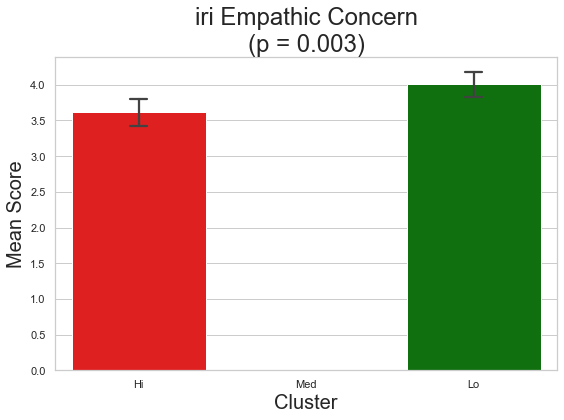

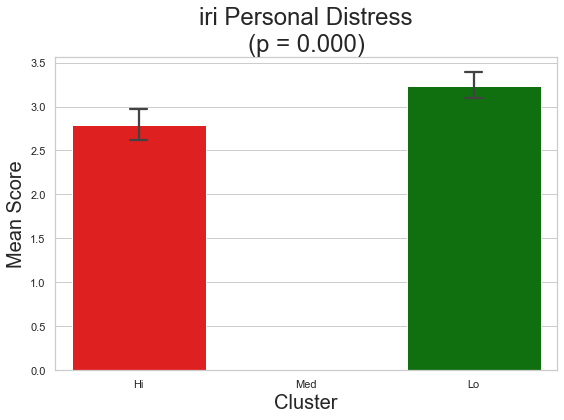

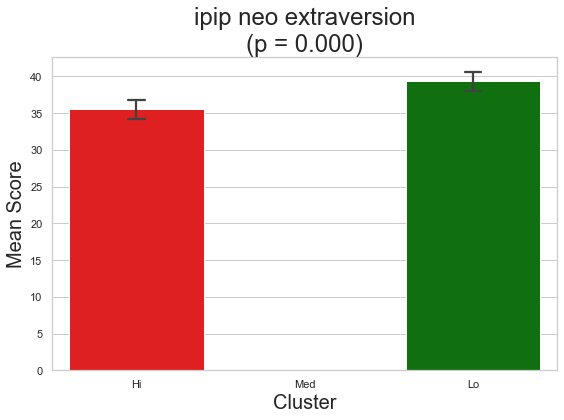

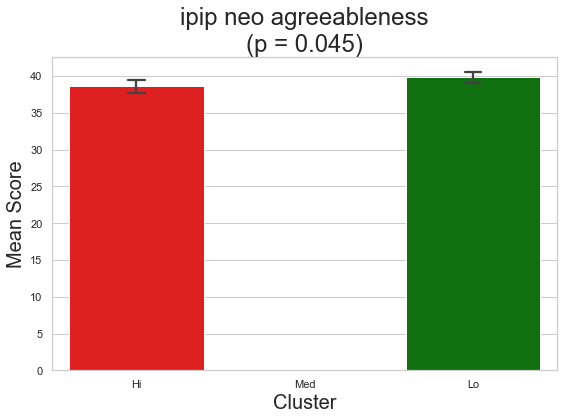

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f_oneway
import pandas as pd

# --- Associate Clusters with External Variables (BSI, IRI, IPIP-NEO) ---

# 1. Define all the score columns we've created

all_questionnaire_cols = bsi_score_cols + iri_cols + ipip_cols

# 2. Merge cluster assignments with the questionnaire data
# 'between_clustered' has the 'Cluster' column for each participant
# 'postQDat' has all the questionnaire scores
cluster_analysis_df = between_clustered[['Cluster']].merge(
    postQDat[all_questionnaire_cols],
    left_index=True,
    right_index=True,
    how='inner'
)

# 3. Calculate mean scores for each cluster
cluster_means = cluster_analysis_df.groupby('Cluster')[all_questionnaire_cols].mean()

# 4. Perform ANOVA to test for significant differences between clusters
anova_results = []
for col in all_questionnaire_cols:
    # Create a list of arrays, one for each cluster
    groups = [cluster_analysis_df[col][cluster_analysis_df['Cluster'] == i].dropna() for i in range(OPTIMAL_K)]
    
    # Check if there are enough data points in each group for ANOVA
    if all(len(g) > 1 for g in groups):
        f_stat, p_val = f_oneway(*groups)
        anova_results.append({
            'Variable': col,
            'F-statistic': f_stat,
            'p-value': p_val
        })
    else:
        anova_results.append({
            'Variable': col,
            'F-statistic': None,
            'p-value': None
        })

anova_results_df = pd.DataFrame(anova_results).set_index('Variable')

# Add significance markers to the mean table
def highlight_sig(val):
    if pd.isna(val):
        return ''
    return 'background-color: yellow' if val < 0.05 else ''

# Combine means and ANOVA results for a comprehensive view
# BSI Results
bsi_means = cluster_means[bsi_score_cols].T
bsi_anova = anova_results_df.loc[bsi_score_cols]
bsi_summary = bsi_means.join(bsi_anova)
print("\n--- BSI Scores by Cluster ---")
print("Mean scores for each BSI dimension across the 3 clusters. Yellow highlight indicates a significant difference (p < 0.05) between clusters.")
display(bsi_summary.style.applymap(highlight_sig, subset=['p-value']).format('{:.2f}'))

# IRI Results
iri_means = cluster_means[iri_cols].T
iri_anova = anova_results_df.loc[iri_cols]
iri_summary = iri_means.join(iri_anova)
print("\n--- IRI Scores by Cluster ---")
print("Mean scores for each IRI dimension across the 3 clusters. Yellow highlight indicates a significant difference (p < 0.05) between clusters.")
display(iri_summary.style.applymap(highlight_sig, subset=['p-value']).format('{:.2f}'))

# IPIP-NEO Results
ipip_means = cluster_means[ipip_cols].T
ipip_anova = anova_results_df.loc[ipip_cols]
ipip_summary = ipip_means.join(ipip_anova)
print("\n--- IPIP-NEO Scores by Cluster ---")
print("Mean scores for each IPIP-NEO dimension across the 3 clusters. Yellow highlight indicates a significant difference (p < 0.05) between clusters.")
display(ipip_summary.style.applymap(highlight_sig, subset=['p-value']).format('{:.2f}'))


# --- Visualize Significant Differences with Custom Cluster Labels ---

# 1. Determine the order of clusters based on BSI Global score
# We assume 'Lo', 'Med', 'Hi' correspond to low, medium, and high psychopathology.
cluster_order_df = cluster_analysis_df.groupby('Cluster')['BSI_Global'].mean().sort_values()
cluster_mapping = {cluster_order_df.index[0]: 'Hi', 
                   cluster_order_df.index[1]: 'Lo' 
                   }

# Create a new DataFrame with the mapped labels for plotting
plot_df = cluster_analysis_df.copy()
plot_df['Cluster_Label'] = plot_df['Cluster'].map(cluster_mapping)

# Define the order for the x-axis in the plots
plot_order = ['Hi', 'Med', 'Lo']

# 2. Identify variables with significant differences
significant_vars = anova_results_df[anova_results_df['p-value'] < 0.05].index.tolist()

if not significant_vars:
    print("No significant differences found between clusters for any questionnaire variables.")
else:
    print(f"Found {len(significant_vars)} variables with significant differences. Generating plots...")
    
    # Set plot style and a color palette for the clusters
    sns.set(style="whitegrid")
    # Create a palette that maps specific colors to our new labels
    palette = {'Lo': 'green', 'Med': 'orange', 'Hi': 'red'}
    
    # 3. Loop through each significant variable and create a separate plot
    for var in significant_vars:
        plt.figure(figsize=(8, 6)) # Create a new figure for each plot
        
        # Use seaborn to create a bar plot with the new labels and order
        ax = sns.barplot(data=plot_df, x='Cluster_Label', y=var, order=plot_order, 
                         capsize=.1, palette=palette)
        
        p_val = anova_results_df.loc[var, 'p-value']
        ax.set_title(f'{var.replace("_", " ")}\n(p = {p_val:.3f})', fontsize=24)
        ax.set_xlabel('Cluster', fontsize=20)
        ax.set_ylabel('Mean Score', fontsize=20)
        
        plt.tight_layout()
        plt.show()

==================== BETWEEN-PERSON PCA ====================
Analyzing the principal components of stable, individual differences in thought.

Data for Between-Person PCA has 133 participants.


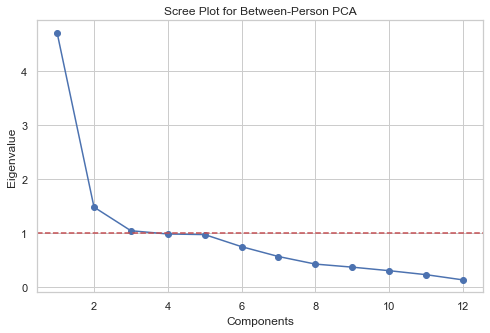


Scree plot suggests retaining 3 components for the between-person analysis.

--- Between-Person Component Loadings (Varimax Rotation) ---


,Between Comp. 1,Between Comp. 2,Between Comp. 3
visImag,0.603266,0.134668,-0.124792
inSpeech,0.252751,0.063877,0.777433
intent,0.063184,0.607278,-0.078326
struct,0.621417,0.503820,0.070093
real,0.233213,0.793813,0.308699
concAbs,0.117496,0.870792,0.158568
import,0.652967,0.491625,0.141836
relGoal,0.752989,0.252876,0.096123
fullDev,0.491061,0.621954,-0.142884
oftMind,0.838433,-0.044776,0.202790




==================== WITHIN-PERSON PCA ====================
Analyzing the principal components of moment-to-moment fluctuations in thought.

Data for Within-Person PCA has 2202 observations.


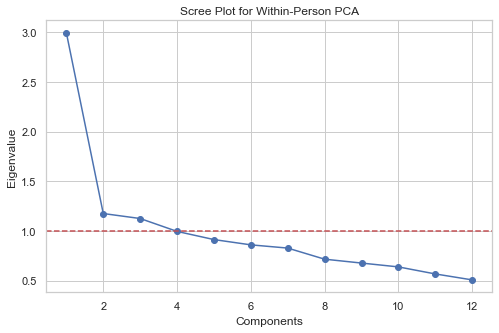


Scree plot suggests retaining 3 components for the within-person analysis.

--- Within-Person Component Loadings (Varimax Rotation) ---


,Within Comp. 1,Within Comp. 2,Within Comp. 3
visImag,0.230791,-0.553624,0.280707
inSpeech,0.097630,0.608885,0.020753
intent,0.442349,-0.112001,0.115029
struct,0.456716,0.245068,-0.003890
real,0.700998,0.071387,-0.015488
concAbs,0.724743,-0.061048,-0.078349
import,0.659996,0.276679,0.096152
relGoal,0.539462,0.346092,0.163959
fullDev,0.687077,-0.006383,0.043581
oftMind,0.258145,0.464348,0.187310


In [34]:
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

# --- Multilevel Principal Component Analysis (MPCA) ---

# --- 1. Between-Person PCA ---
print("="*20 + " BETWEEN-PERSON PCA " + "="*20)
print("Analyzing the principal components of stable, individual differences in thought.")

# Prepare and scale data
# Using the same tcq_cols as the EFA
between_pca_data = between[tcq_cols].dropna()
scaler_b = StandardScaler()
between_pca_scaled = pd.DataFrame(scaler_b.fit_transform(between_pca_data), index=between_pca_data.index, columns=between_pca_data.columns)

print(f"\nData for Between-Person PCA has {between_pca_scaled.shape[0]} participants.")

# Determine number of components (Scree Plot)
fa_between_scree_pca = FactorAnalyzer(n_factors=between_pca_scaled.shape[1], rotation=None, method='principal')
fa_between_scree_pca.fit(between_pca_scaled)
ev_b_pca, v_b_pca = fa_between_scree_pca.get_eigenvalues()
n_components_between = sum(ev_b_pca > 1)

plt.figure(figsize=(8, 5))
plt.scatter(range(1, between_pca_scaled.shape[1] + 1), ev_b_pca)
plt.plot(range(1, between_pca_scaled.shape[1] + 1), ev_b_pca)
plt.title('Scree Plot for Between-Person PCA')
plt.xlabel('Components')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.grid(True)
plt.show()

print(f"\nScree plot suggests retaining {n_components_between} components for the between-person analysis.")

# Run the PCA with Varimax rotation
fa_between_pca = FactorAnalyzer(n_factors=n_components_between, rotation="varimax", method='principal')
fa_between_pca.fit(between_pca_scaled)

# Display loadings
between_loadings_pca_df = pd.DataFrame(
    fa_between_pca.loadings_, 
    index=between_pca_scaled.columns, 
    columns=[f'Between Comp. {i+1}' for i in range(n_components_between)]
)
print("\n--- Between-Person Component Loadings (Varimax Rotation) ---")
display(between_loadings_pca_df.style.apply(lambda x: ['background: lightgreen' if abs(val) > 0.4 else '' for val in x], axis=1))

# --- 2. Within-Person PCA ---
print("\n\n" + "="*20 + " WITHIN-PERSON PCA " + "="*20)
print("Analyzing the principal components of moment-to-moment fluctuations in thought.")

# Prepare and scale data
within_pca_data = within[tcq_cols].dropna()
scaler_w = StandardScaler()
within_pca_scaled = pd.DataFrame(scaler_w.fit_transform(within_pca_data), index=within_pca_data.index, columns=within_pca_data.columns)

print(f"\nData for Within-Person PCA has {within_pca_scaled.shape[0]} observations.")

# Determine number of components (Scree Plot)
fa_within_scree_pca = FactorAnalyzer(n_factors=within_pca_scaled.shape[1], rotation=None, method='principal')
fa_within_scree_pca.fit(within_pca_scaled)
ev_w_pca, v_w_pca = fa_within_scree_pca.get_eigenvalues()
n_components_within = sum(ev_w_pca > 1)

plt.figure(figsize=(8, 5))
plt.scatter(range(1, within_pca_scaled.shape[1] + 1), ev_w_pca)
plt.plot(range(1, within_pca_scaled.shape[1] + 1), ev_w_pca)
plt.title('Scree Plot for Within-Person PCA')
plt.xlabel('Components')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.grid(True)
plt.show()

print(f"\nScree plot suggests retaining {n_components_within} components for the within-person analysis.")

# Run the PCA with Varimax rotation
fa_within_pca = FactorAnalyzer(n_factors=n_components_within, rotation="varimax", method='principal')
fa_within_pca.fit(within_pca_scaled)

# Display loadings
within_loadings_pca_df = pd.DataFrame(
    fa_within_pca.loadings_, 
    index=within_pca_scaled.columns, 
    columns=[f'Within Comp. {i+1}' for i in range(n_components_within)]
)
print("\n--- Within-Person Component Loadings (Varimax Rotation) ---")
display(within_loadings_pca_df.style.apply(lambda x: ['background: lightgreen' if abs(val) > 0.4 else '' for val in x], axis=1))


==================== CORRELATIONS WITH BETWEEN-PERSON PCA COMPONENTS ====================


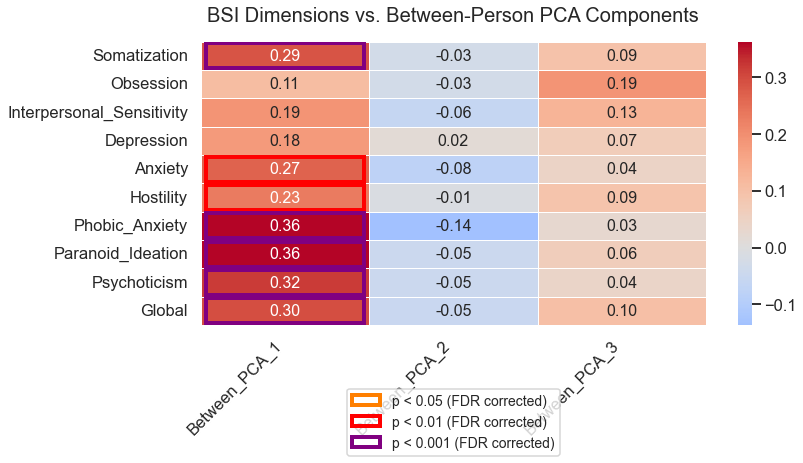

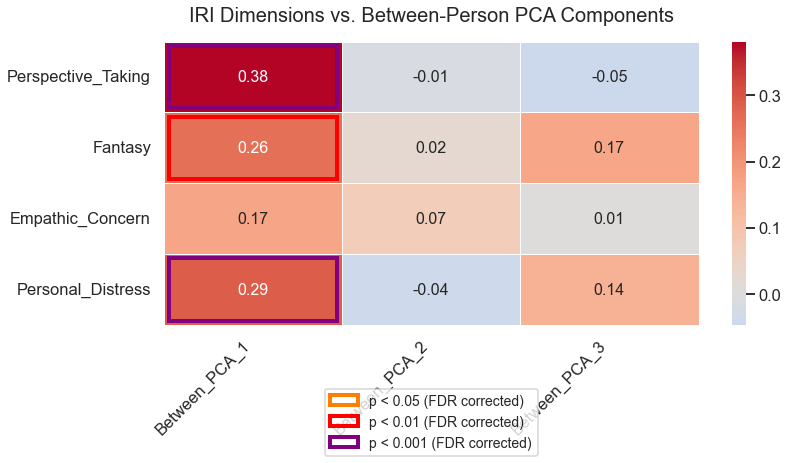

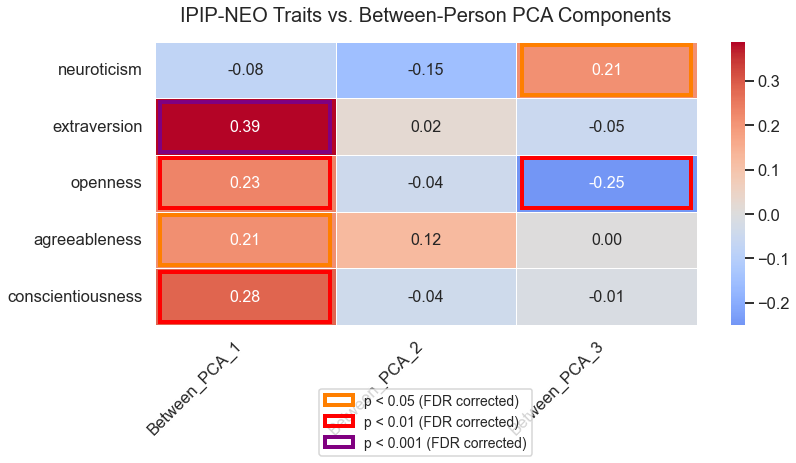


==================== CORRELATIONS WITH WITHIN-PERSON PCA COMPONENTS ====================


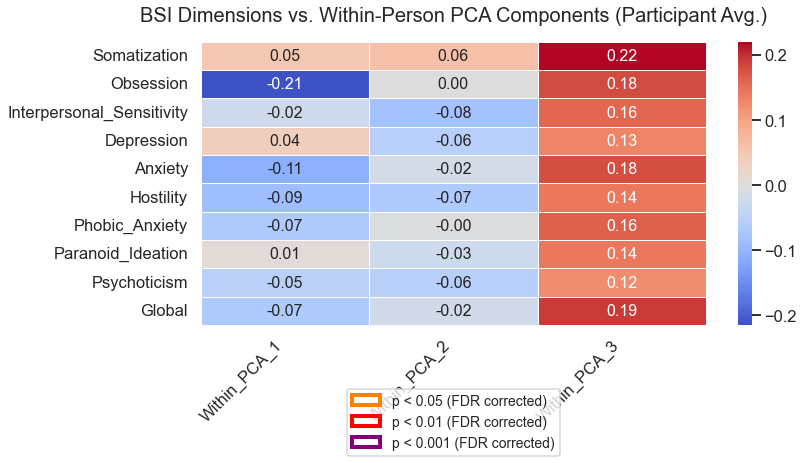

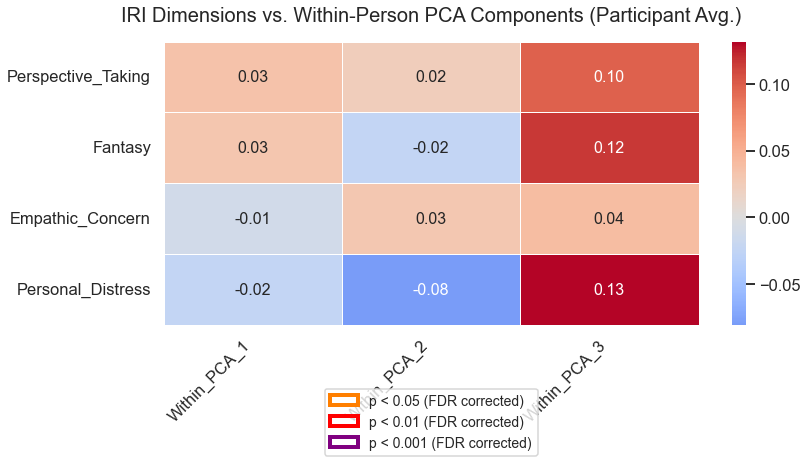

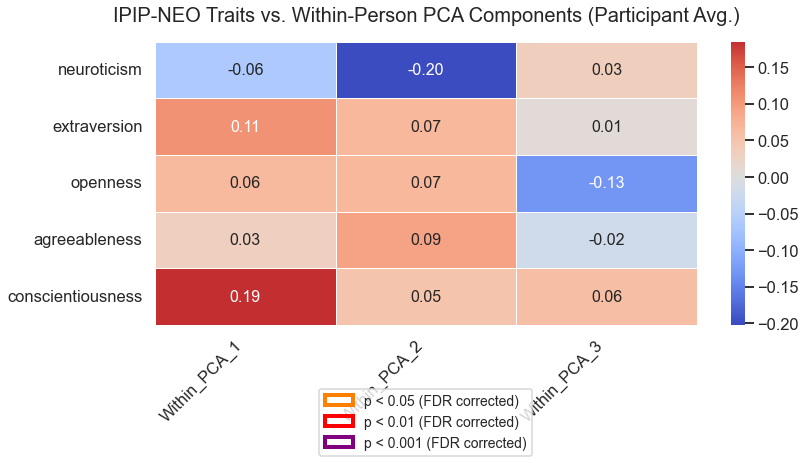

In [35]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection

# --- Correlate Multilevel PCA Component Scores with Questionnaire Data ---

# 1. Calculate Between-Person PCA component scores
# Use the 'fa_between_pca' object and the data it was fitted on ('between_pca_scaled')
between_component_scores = fa_between_pca.transform(between_pca_scaled)
between_component_scores_df = pd.DataFrame(
    between_component_scores,
    index=between_pca_scaled.index,
    columns=[f'Between_PCA_{i+1}' for i in range(n_components_between)]
)

# 2. Calculate Within-Person PCA component scores for each episode
# Use 'fa_within_pca' on the within-person data ('within_pca_scaled')
within_component_scores_obs = fa_within_pca.transform(within_pca_scaled)
within_component_scores_obs_df = pd.DataFrame(
    within_component_scores_obs,
    index=within_pca_scaled.index,
    columns=[f'Within_PCA_{i+1}' for i in range(n_components_within)]
)
# Add participant ID to aggregate scores to the participant level
within_scores_with_id = within_pca_data.join(within_component_scores_obs_df).join(tcqData['expiwellID'])
# Group by participant and calculate the mean score for each within-person component
participant_within_scores = within_scores_with_id.groupby('expiwellID')[[f'Within_PCA_{i+1}' for i in range(n_components_within)]].mean()


# 3. Prepare the master analysis DataFrame
# Define all questionnaire columns



# Merge both sets of component scores
mpca_scores_df = between_component_scores_df.join(participant_within_scores, how='inner')
# Merge with all questionnaire scores
mpca_analysis_df = mpca_scores_df.merge(
    postQDat[all_questionnaire_cols],
    left_index=True,
    right_index=True,
    how='inner'
)

# Define the new PCA component columns
between_pca_cols = between_component_scores_df.columns.tolist()
within_pca_cols = participant_within_scores.columns.tolist()

# Ensure all columns for analysis are numeric
for col in between_pca_cols + within_pca_cols + all_questionnaire_cols:
    if col in mpca_analysis_df.columns:
        mpca_analysis_df[col] = pd.to_numeric(mpca_analysis_df[col], errors='coerce')

# --- Function to run and visualize correlations ---
def run_correlation_analysis(df, x_cols, y_cols, title):
    """
    Calculates and visualizes a correlation matrix between two sets of columns.
    Includes FDR correction and significance highlighting on the heatmap.
    """
    # Calculate correlation matrix and p-values
    corr_matrix = pd.DataFrame(index=y_cols, columns=x_cols, dtype=float)
    p_matrix = pd.DataFrame(index=y_cols, columns=x_cols, dtype=float)
    all_p_values = []
    locations = []

    for y_col in y_cols:
        for x_col in x_cols:
            temp_df = df[[y_col, x_col]].dropna()
            if temp_df.shape[0] > 2:
                r, p = pearsonr(temp_df[x_col], temp_df[y_col])
                corr_matrix.loc[y_col, x_col] = r
                p_matrix.loc[y_col, x_col] = p
                all_p_values.append(p)
                locations.append((y_col, x_col))

    if not all_p_values:
        print(f"Could not calculate any correlations for {title}.")
        return

    _, p_corrected = fdrcorrection(all_p_values, alpha=0.05)
    q_matrix = pd.DataFrame(np.nan, index=y_cols, columns=x_cols, dtype=float)
    for i, (y_col, x_col) in enumerate(locations):
        q_matrix.loc[y_col, x_col] = p_corrected[i]

    # --- Visualization ---
    sns.set_context('talk')
    plt.figure(figsize=(12, max(8, len(y_cols) * 0.6)))
    
    ax = sns.heatmap(
        corr_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap='coolwarm', 
        center=0,
        
        linewidths=.5,
        annot_kws={"size": 16}
    )

    # Add significance boxes
    for y_idx, y_col in enumerate(y_cols):
        for x_idx, x_col in enumerate(x_cols):
            q_val = q_matrix.loc[y_col, x_col]
            if pd.notna(q_val) and q_val < 0.05:
                p_val = p_matrix.loc[y_col, x_col]
                edge_color = 'purple' if p_val < 0.001 else ('#FF0000' if p_val < 0.01 else '#ff7f00')
                ax.add_patch(patches.Rectangle((x_idx + 0.03, y_idx + 0.06), 0.94, 0.88, fill=False, edgecolor=edge_color, lw=4))

    legend_patches = [
        patches.Patch(edgecolor='#ff7f00', facecolor='none', lw=4, label='p < 0.05 (FDR corrected)'),
        patches.Patch(edgecolor='#FF0000', facecolor='none', lw=4, label='p < 0.01 (FDR corrected)'),
        patches.Patch(edgecolor='purple', facecolor='none', lw=4, label='p < 0.001 (FDR corrected)')
    ]
    ax.legend(handles=legend_patches, bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=1, fontsize=14)
    
    cleaned_y_labels = [label.get_text().replace('BSI_', '').replace('iri_', '').replace('ipip_neo_', '') for label in ax.get_yticklabels()]
    ax.set_yticklabels(cleaned_y_labels)
    plt.title(title, fontsize=20, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()
    sns.set_context('notebook')

# --- Run Analysis for Each Questionnaire ---

# --- 4. Run Correlation Analysis for Each Questionnaire vs. MPCA Components ---

# --- BETWEEN-PERSON COMPONENTS ---
print("\n" + "="*20 + " CORRELATIONS WITH BETWEEN-PERSON PCA COMPONENTS " + "="*20)
run_correlation_analysis(
    df=mpca_analysis_df, 
    x_cols=between_pca_cols, 
    y_cols=bsi_score_cols, 
    title='BSI Dimensions vs. Between-Person PCA Components'
)
run_correlation_analysis(
    df=mpca_analysis_df, 
    x_cols=between_pca_cols, 
    y_cols=iri_cols, 
    title='IRI Dimensions vs. Between-Person PCA Components'
)
run_correlation_analysis(
    df=mpca_analysis_df, 
    x_cols=between_pca_cols, 
    y_cols=ipip_cols, 
    title='IPIP-NEO Traits vs. Between-Person PCA Components'
)

# --- WITHIN-PERSON COMPONENTS ---
print("\n" + "="*20 + " CORRELATIONS WITH WITHIN-PERSON PCA COMPONENTS " + "="*20)
run_correlation_analysis(
    df=mpca_analysis_df, 
    x_cols=within_pca_cols, 
    y_cols=bsi_score_cols, 
    title='BSI Dimensions vs. Within-Person PCA Components (Participant Avg.)'
)
run_correlation_analysis(
    df=mpca_analysis_df, 
    x_cols=within_pca_cols, 
    y_cols=iri_cols, 
    title='IRI Dimensions vs. Within-Person PCA Components (Participant Avg.)'
)
run_correlation_analysis(
    df=mpca_analysis_df, 
    x_cols=within_pca_cols, 
    y_cols=ipip_cols, 
    title='IPIP-NEO Traits vs. Within-Person PCA Components (Participant Avg.)'
)

In [36]:
import warnings
warnings.filterwarnings('ignore')

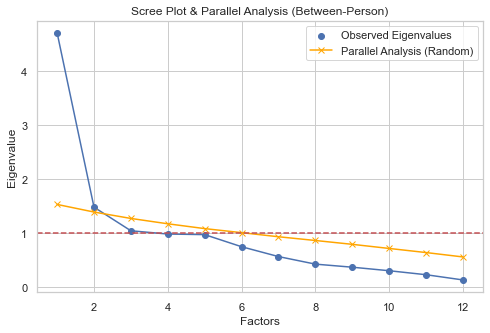

Suggested number of factors (Observed > Parallel): 2


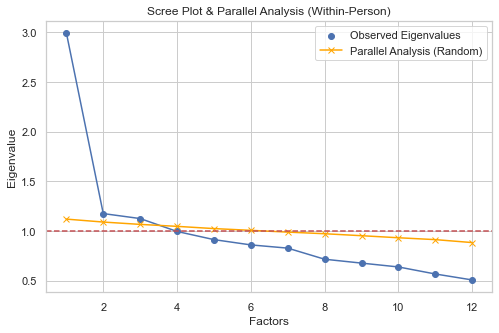

Suggested number of factors (Observed > Parallel): 3


In [37]:
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo, Rotator
import numpy as np
import matplotlib.pyplot as plt

def run_parallel_analysis(data, n_iter=100, random_state=42):
    n_obs, n_vars = data.shape
    rng = np.random.default_rng(random_state)
    rand_eigs = np.zeros((n_iter, n_vars))
    for i in range(n_iter):
        rand_data = rng.normal(size=(n_obs, n_vars))
        fa_rand = FactorAnalyzer(n_factors=n_vars, rotation=None)
        fa_rand.fit(rand_data)
        rand_eigs[i, :] = fa_rand.get_eigenvalues()[0]
    mean_rand_eigs = rand_eigs.mean(axis=0)
    return mean_rand_eigs

# Example for between-person EFA
between_efa_data = between[tcq_cols].dropna()
fa_between = FactorAnalyzer(n_factors=between_efa_data.shape[1], rotation=None)
fa_between.fit(between_efa_data)
ev_b, v_b = fa_between.get_eigenvalues()

# Parallel analysis
mean_rand_eigs_b = run_parallel_analysis(between_efa_data)

plt.figure(figsize=(8, 5))
plt.scatter(range(1, len(ev_b) + 1), ev_b, label='Observed Eigenvalues')
plt.plot(range(1, len(ev_b) + 1), ev_b)
plt.plot(range(1, len(ev_b) + 1), mean_rand_eigs_b, color='orange', marker='x', label='Parallel Analysis (Random)')
plt.title('Scree Plot & Parallel Analysis (Between-Person)')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

print(f"Suggested number of factors (Observed > Parallel): {(ev_b > mean_rand_eigs_b).sum()}")

# Repeat for within-person EFA
within_efa_data = within[tcq_cols].dropna()
fa_within = FactorAnalyzer(n_factors=within_efa_data.shape[1], rotation=None)
fa_within.fit(within_efa_data)
ev_w, v_w = fa_within.get_eigenvalues()
mean_rand_eigs_w = run_parallel_analysis(within_efa_data)

plt.figure(figsize=(8, 5))
plt.scatter(range(1, len(ev_w) + 1), ev_w, label='Observed Eigenvalues')
plt.plot(range(1, len(ev_w) + 1), ev_w)
plt.plot(range(1, len(ev_w) + 1), mean_rand_eigs_w, color='orange', marker='x', label='Parallel Analysis (Random)')
plt.title('Scree Plot & Parallel Analysis (Within-Person)')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

print(f"Suggested number of factors (Observed > Parallel): {(ev_w > mean_rand_eigs_w).sum()}")

==================== BETWEEN-PERSON EFA ====================
Analyzing the structure of stable, individual differences in thought.

Data for Between-Person EFA has 133 participants.
KMO Test for Between-Person Data: 0.793
Bartlett's Test: chi-square = 568.57, p-value = 8.88e-92


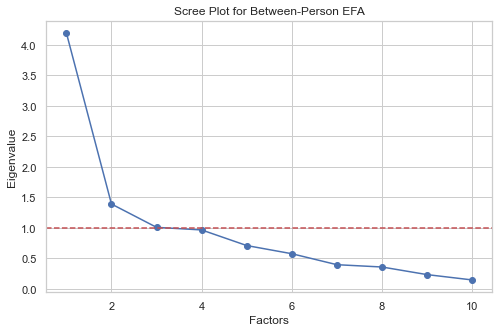


Scree plot suggests retaining 3 factors for the between-person analysis.

--- Between-Person Factor Loadings (Promax Rotation) ---


,Between Factor 1,Between Factor 2
visImag,0.508530,-0.002751
inSpeech,0.121257,0.205168
intent,0.085893,0.300049
struct,0.540587,0.282283
real,-0.133982,1.008228
concAbs,-0.243779,1.005206
import,0.547380,0.367073
relGoal,0.776324,0.011951
oftMind,0.858056,-0.221919
emotVal,0.582602,-0.041950



--- Variance Explained by Each Between-Person Factor ---


,SS Loadings,% of Variance,Cumulative %
Between Factor 1,262.83,26.28%,26.28%
Between Factor 2,242.47,24.25%,50.53%




==================== WITHIN-PERSON EFA ====================
Analyzing the structure of moment-to-moment fluctuations in thought.

Data for Within-Person EFA has 2202 observations.
KMO Test for Within-Person Data: 0.791
Bartlett's Test: chi-square = 2469.70, p-value = 0


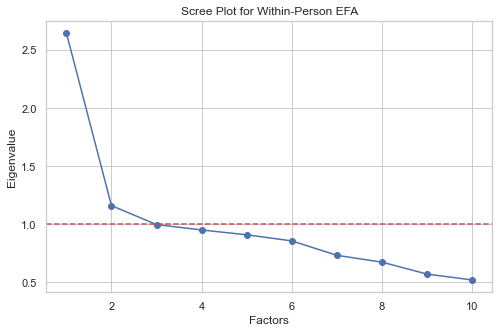


Scree plot suggests retaining 2 factors for the within-person analysis.

--- Within-Person Factor Loadings (Promax Rotation) ---


,Within Factor 1,Within Factor 2,Within Factor 3
visImag,0.231782,0.031124,-0.154414
inSpeech,-0.075090,0.137767,0.239777
intent,0.269251,0.040832,0.074475
struct,0.101066,0.973896,-0.017735
real,0.576459,-0.024713,0.195431
concAbs,0.626114,0.026589,0.060194
import,0.341520,-0.029030,0.496629
relGoal,0.233068,-0.002803,0.441391
oftMind,-0.003323,-0.062627,0.458633
emotVal,0.243028,-0.030822,0.039523



--- Variance Explained by Each Within-Person Factor ---


,SS Loadings,% of Variance,Cumulative %
Within Factor 1,109.64,10.96%,10.96%
Within Factor 2,97.71,9.77%,20.74%
Within Factor 3,78.24,7.82%,28.56%


In [38]:

from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
import matplotlib.pyplot as plt
tcq_cols = ['visImag', 'inSpeech', 'intent', 'struct', 'real', 'concAbs', 'import', 'relGoal','oftMind', 'emotVal']
# --- Multilevel Exploratory Factor Analysis ---

# --- 1. Between-Person EFA ---
print("="*20 + " BETWEEN-PERSON EFA " + "="*20)
print("Analyzing the structure of stable, individual differences in thought.")

# Prepare data
between_efa_data = between[tcq_cols].dropna()
print(f"\nData for Between-Person EFA has {between_efa_data.shape[0]} participants.")

# Assess data adequacy
kmo_all, kmo_model = calculate_kmo(between_efa_data)
print(f"KMO Test for Between-Person Data: {kmo_model:.3f}")
chi_square_value, p_value = calculate_bartlett_sphericity(between_efa_data)
print(f"Bartlett's Test: chi-square = {chi_square_value:.2f}, p-value = {p_value:.3g}")

# Determine number of factors (Scree Plot)
fa_between_scree = FactorAnalyzer(n_factors=between_efa_data.shape[1], rotation=None)
fa_between_scree.fit(between_efa_data)
ev_b, v_b = fa_between_scree.get_eigenvalues()
n_factors_between = sum(ev_b > 1)

plt.figure(figsize=(8, 5))
plt.scatter(range(1, between_efa_data.shape[1] + 1), ev_b)
plt.plot(range(1, between_efa_data.shape[1] + 1), ev_b)
plt.title('Scree Plot for Between-Person EFA')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.grid(True)
plt.show()

print(f"\nScree plot suggests retaining {n_factors_between} factors for the between-person analysis.")

n_factors_between = 2
# Run the EFA with Promax rotation
fa_between = FactorAnalyzer(n_factors=n_factors_between, rotation="promax")
fa_between.fit(between_efa_data)

# Display loadings
between_loadings_df = pd.DataFrame(
    fa_between.loadings_, 
    index=between_efa_data.columns, 
    columns=[f'Between Factor {i+1}' for i in range(n_factors_between)]
)
print("\n--- Between-Person Factor Loadings (Promax Rotation) ---")
display(between_loadings_df.style.apply(lambda x: ['background: lightgreen' if abs(val) > 0.4 else '' for val in x], axis=1))

# Show variance explained by each factor
variance, prop_var, cum_var = fa_between.get_factor_variance()
variance_df = pd.DataFrame({
    'SS Loadings': variance,
    '% of Variance': prop_var,
    'Cumulative %': cum_var
}, index=[f'Between Factor {i+1}' for i in range(n_factors_between)])

print("\n--- Variance Explained by Each Between-Person Factor ---")
display((variance_df * 100).style.format({'SS Loadings': '{:.2f}', '% of Variance': '{:.2f}%', 'Cumulative %': '{:.2f}%'}))
# --- 2. Within-Person EFA ---
print("\n\n" + "="*20 + " WITHIN-PERSON EFA " + "="*20)
print("Analyzing the structure of moment-to-moment fluctuations in thought.")

# Prepare data
within_efa_data = within[tcq_cols].dropna()
print(f"\nData for Within-Person EFA has {within_efa_data.shape[0]} observations.")

# Assess data adequacy
kmo_all, kmo_model = calculate_kmo(within_efa_data)
print(f"KMO Test for Within-Person Data: {kmo_model:.3f}")
chi_square_value, p_value = calculate_bartlett_sphericity(within_efa_data)
print(f"Bartlett's Test: chi-square = {chi_square_value:.2f}, p-value = {p_value:.3g}")

# Determine number of factors (Scree Plot)
fa_within_scree = FactorAnalyzer(n_factors=within_efa_data.shape[1], rotation=None)
fa_within_scree.fit(within_efa_data)
ev_w, v_w = fa_within_scree.get_eigenvalues()
n_factors_within = sum(ev_w > 1)

plt.figure(figsize=(8, 5))
plt.scatter(range(1, within_efa_data.shape[1] + 1), ev_w)
plt.plot(range(1, within_efa_data.shape[1] + 1), ev_w)
plt.title('Scree Plot for Within-Person EFA')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.grid(True)
plt.show()

print(f"\nScree plot suggests retaining {n_factors_within} factors for the within-person analysis.")
n_factors_within = 3
# Run the EFA with Promax rotation
fa_within = FactorAnalyzer(n_factors=n_factors_within, rotation="promax")
fa_within.fit(within_efa_data)

# Display loadings
within_loadings_df = pd.DataFrame(
    fa_within.loadings_, 
    index=within_efa_data.columns, 
    columns=[f'Within Factor {i+1}' for i in range(n_factors_within)]
)
print("\n--- Within-Person Factor Loadings (Promax Rotation) ---")
display(within_loadings_df.style.apply(lambda x: ['background: lightgreen' if abs(val) > 0.4 else '' for val in x], axis=1)) 


# Show variance explained by each factor
variance, prop_var, cum_var = fa_within.get_factor_variance()
variance_df = pd.DataFrame({
    'SS Loadings': variance,
    '% of Variance': prop_var,
    'Cumulative %': cum_var
}, index=[f'Within Factor {i+1}' for i in range(n_factors_within)])

print("\n--- Variance Explained by Each Within-Person Factor ---")
display((variance_df * 100).style.format({'SS Loadings': '{:.2f}', '% of Variance': '{:.2f}%', 'Cumulative %': '{:.2f}%'}))

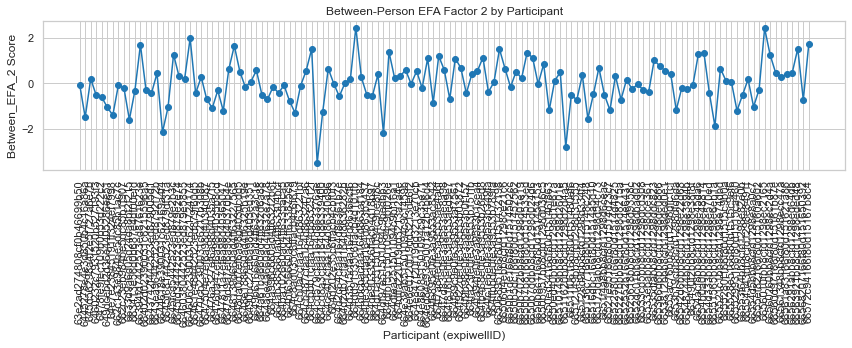

In [39]:
import matplotlib.pyplot as plt

# Plot Between Factor 2 by participant (expiwellID)
plt.figure(figsize=(12, 5))
plt.plot(between_factor_scores_df.index, between_factor_scores_df['Between_EFA_2'], marker='o', linestyle='-', color='tab:blue')
plt.title('Between-Person EFA Factor 2 by Participant')
plt.xlabel('Participant (expiwellID)')
plt.ylabel('Between_EFA_2 Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [44]:
# Ensure 'Start Date' is datetime before applying function
if not pd.api.types.is_datetime64_any_dtype(tcqData['Start Date']):
    tcqData['Start Date'] = pd.to_datetime(tcqData['Start Date'])

def is_probe_in_workhour(row, postQDat):
    eid = row['expiwellID']
    weekday = row['Start Date'].weekday() + 1  # Monday=1, Sunday=7
    hour = row['Start Date'].hour

    start_col = f"Q26#1_{weekday}_time"
    end_col = f"Q26#2_{weekday}_time"
    if eid not in postQDat.index:
        return False

    start_time = postQDat.loc[eid, start_col]
    end_time = postQDat.loc[eid, end_col]

    if pd.isna(start_time) or pd.isna(end_time):
        return False

    start_hr = int(start_time.split(":")[0])
    end_hr = int(end_time.split(":")[0])

    if end_hr <= start_hr:
        return (hour >= start_hr or hour < end_hr)
    else:
        return (hour >= start_hr and hour < end_hr)

tcqData['WorkHour'] = tcqData.apply(lambda row: is_probe_in_workhour(row, postQDat), axis=1)

# Calculate factor scores for each episode (within-person)
within_factor_scores = fa_within.transform(within_efa_data)
within_factor_scores_df = pd.DataFrame(
    within_factor_scores,
    index=within_efa_data.index,
    columns=[f'Within_EFA_{i+1}' for i in range(n_factors_within)]
)


weekday_work = tcqData['WorkHour']
weekday_nonwork = ~tcqData['WorkHour']# FDR correction for WorkHour t-tests
pvals_workhour = []
tvals_workhour = []
for col in within_factor_scores_df.columns:
    work = within_factor_scores_df.loc[weekday_work, col].dropna()
    nonwork = within_factor_scores_df.loc[weekday_nonwork, col].dropna()
    t, p = ttest_ind(work, nonwork, equal_var=False)
    tvals_workhour.append(t)
    pvals_workhour.append(p)

rejected_workhour, qvals_workhour = fdrcorrection(pvals_workhour, alpha=0.05)

print("\n=== T-tests for Within-Person EFA Factors by WorkHour (FDR-corrected, * q<0.05) ===")
for i, col in enumerate(within_factor_scores_df.columns):
    sig = '*' if qvals_workhour[i] < 0.05 else ''
    print(f"{col}: WorkHour t={tvals_workhour[i]:.2f}, p={pvals_workhour[i]:.3g}, q={qvals_workhour[i]:.3g} {sig}")



=== T-tests for Within-Person EFA Factors by WorkHour (FDR-corrected, * q<0.05) ===
Within_EFA_1: WorkHour t=2.13, p=0.033, q=0.099 
Within_EFA_2: WorkHour t=1.24, p=0.216, q=0.263 
Within_EFA_3: WorkHour t=1.12, p=0.263, q=0.263 


In [ ]:
""" # Calculate factor scores for each participant (between-person)
between_factor_scores = fa_between.transform(between_efa_data)
between_factor_scores_df = pd.DataFrame(
    between_factor_scores,
    index=between_efa_data.index,
    columns=[f'Between_EFA_{i+1}' for i in range(n_factors_between)]
)
print("\n=== T-tests for Between-Person EFA Factors by WorkHour and IsWeekend ===")
for col in between_factor_scores_df.columns:
    work = between_factor_scores_df.loc[tcqData['WorkHour'], col].dropna()
    nonwork = between_factor_scores_df.loc[~tcqData['WorkHour'], col].dropna()
    t1, p1 = ttest_ind(work, nonwork, equal_var=False)
    weekday = between_factor_scores_df.loc[~tcqData['IsWeekend'], col].dropna()
    weekend = between_factor_scores_df.loc[tcqData['IsWeekend'], col].dropna()
    t2, p2 = ttest_ind(weekday, weekend, equal_var=False)
    print(f"{col}: WorkHour t={t1:.2f}, p={p1:.3g} {'*' if p1<0.05 else ''} | Weekend t={t2:.2f}, p={p2:.3g} {'*' if p2<0.05 else ''}") """



--- Mean Between-Person EFA Factor Scores (First 5) ---


,Between_EFA_1,Between_EFA_2
63e2ad274808cf0b46699b50,-1.865566,-0.050116
6445278e4e3d850b4c16a86a,-0.599477,-1.487375
645d56298a4f2e5f727a6e7b,0.610023,0.197195
6460232c7931520b527193f3,-1.852908,-0.521707
6478fe9fec109b0b53d222c2,-0.611764,-0.605659



--- Mean Within-Person EFA Factor Scores (First 5) ---


,Within_EFA_1,Within_EFA_2
63e2ad274808cf0b46699b50,1.387779e-17,7.401487e-17
6445278e4e3d850b4c16a86a,-1.387779e-17,0.000000e+00
645d56298a4f2e5f727a6e7b,0.000000e+00,1.040834e-17
6460232c7931520b527193f3,9.349247e-17,2.337312e-17
6478fe9fec109b0b53d222c2,-6.938894e-18,0.000000e+00



==================== CORRELATIONS WITH BETWEEN-PERSON EFA FACTORS ====================


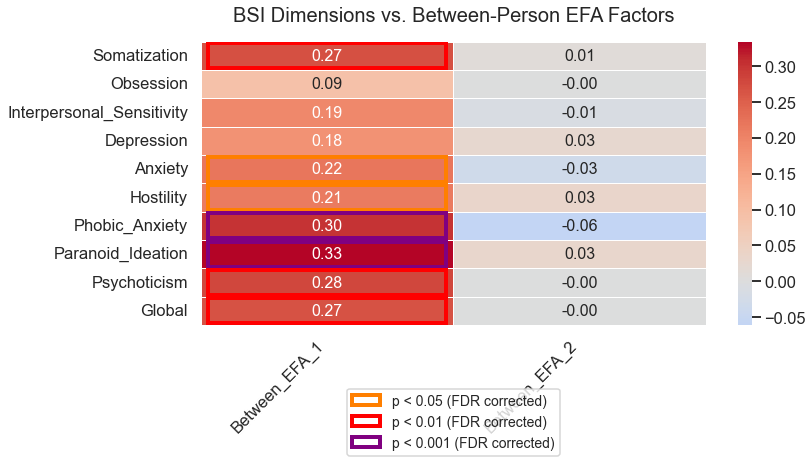

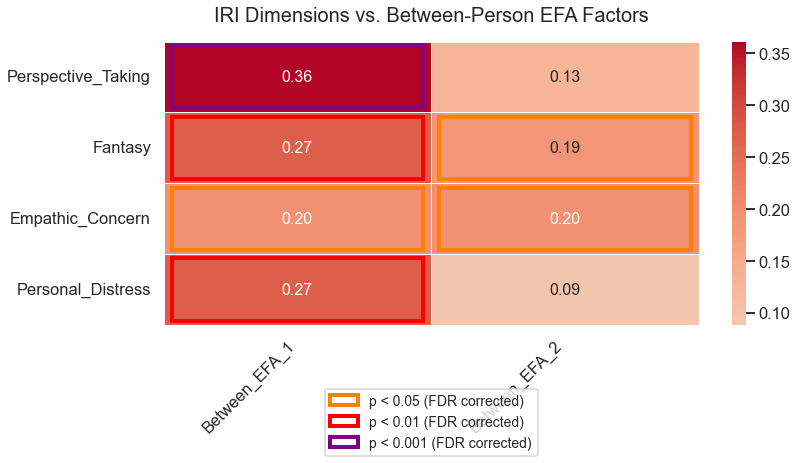

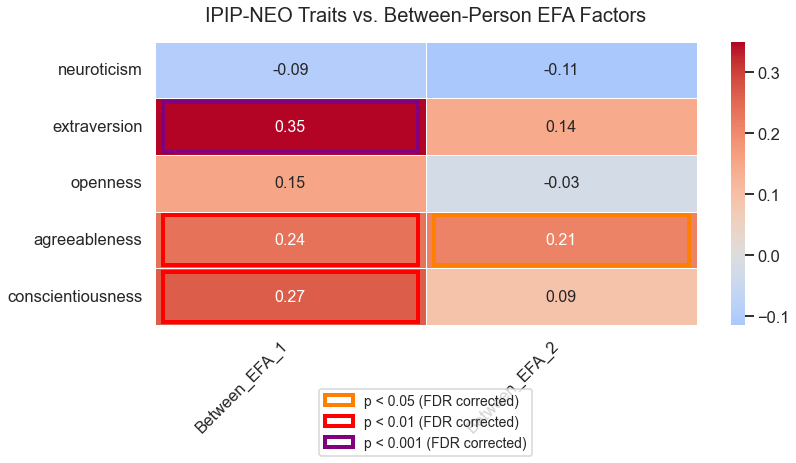


==================== CORRELATIONS WITH WITHIN-PERSON EFA FACTORS ====================


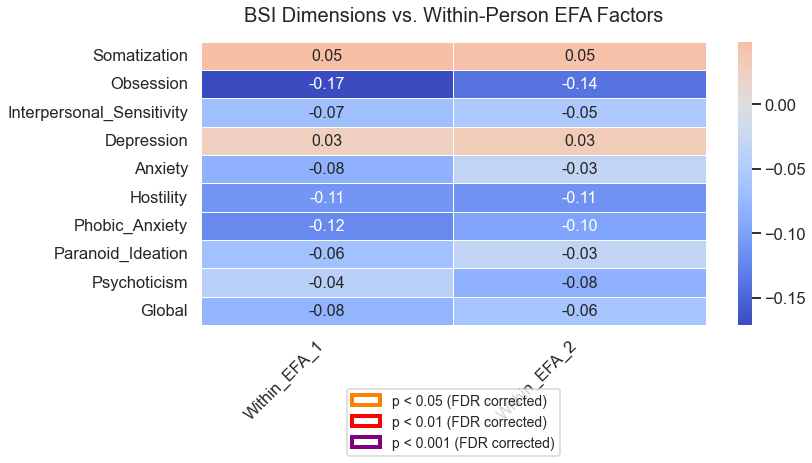

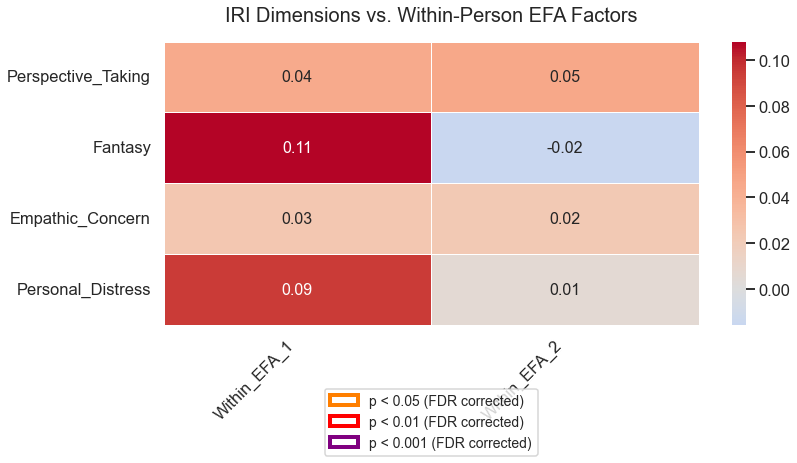

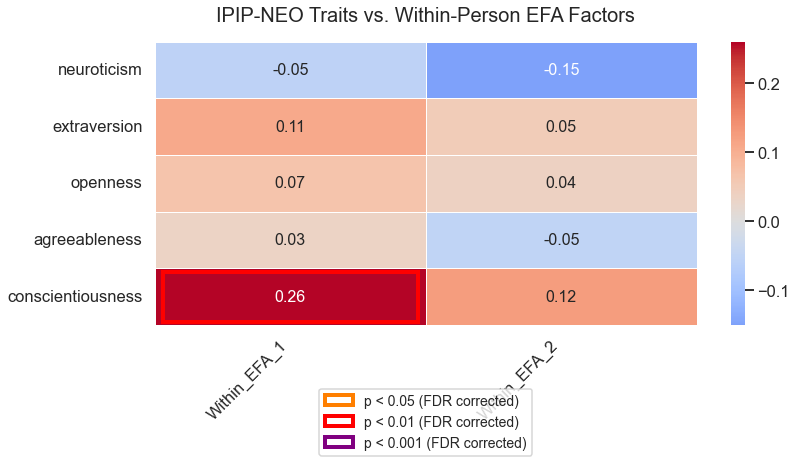

In [ ]:

# --- Correlate MEFA Factor Scores with Questionnaire Data ---

# 1. Calculate Between-Person EFA factor scores
# Use the 'fa_between' object and the data it was fitted on ('between_efa_data')
between_factor_scores = fa_between.transform(between_efa_data)
between_factor_scores_df = pd.DataFrame(
    between_factor_scores,
    index=between_efa_data.index,
    columns=[f'Between_EFA_{i+1}' for i in range(n_factors_between)]
)


# 2. Calculate Within-Person EFA factor scores
# Use 'fa_within' on the within-person data ('within_efa_data') to get scores for each episode
within_factor_scores_obs = fa_within.transform(within_efa_data)
within_factor_scores_obs_df = pd.DataFrame(
    within_factor_scores_obs,
    index=within_efa_data.index,
    columns=[f'Within_EFA_{i+1}' for i in range(n_factors_within)]
)
# Add expiwellID to aggregate scores to the participant level
# FIX: Join with tcqData['expiwellID'] which aligns with the index of within_efa_data
within_scores_with_id = within_efa_data.join(within_factor_scores_obs_df).join(tcqData['expiwellID'])
# FIX: Group by 'expiwellID' to match the index of the between-level data
participant_within_scores = within_scores_with_id.groupby('expiwellID')[[f'Within_EFA_{i+1}' for i in range(n_factors_within)]].mean()


# 3. Prepare the master analysis DataFrame
# Merge both sets of factor scores
mefa_scores_df = between_factor_scores_df.join(participant_within_scores, how='inner')
# Merge with all questionnaire scores
mefa_analysis_df = mefa_scores_df.merge(
    postQDat[all_questionnaire_cols],
    left_index=True,
    right_index=True,
    how='inner'
)

# Define the new EFA factor columns
between_efa_cols = between_factor_scores_df.columns.tolist()
within_efa_cols = [f'Within_EFA_{i+1}' for i in range(n_factors_within)]

print("\n--- Mean Between-Person EFA Factor Scores (First 5) ---")
display(mefa_analysis_df[between_efa_cols].head())
print("\n--- Mean Within-Person EFA Factor Scores (First 5) ---")
display(mefa_analysis_df[within_efa_cols].head())


# 4. Run Correlation Analysis for Each Questionnaire vs. MEFA Factors

# --- BETWEEN-PERSON FACTORS ---
print("\n" + "="*20 + " CORRELATIONS WITH BETWEEN-PERSON EFA FACTORS " + "="*20)
run_correlation_analysis(
    df=mefa_analysis_df, 
    x_cols=between_efa_cols, 
    y_cols=bsi_score_cols, 
    title='BSI Dimensions vs. Between-Person EFA Factors'
)
run_correlation_analysis(
    df=mefa_analysis_df, 
    x_cols=between_efa_cols, 
    y_cols=iri_cols, 
    title='IRI Dimensions vs. Between-Person EFA Factors'
)
run_correlation_analysis(
    df=mefa_analysis_df, 
    x_cols=between_efa_cols, 
    y_cols=ipip_cols, 
    title='IPIP-NEO Traits vs. Between-Person EFA Factors'
)

# --- WITHIN-PERSON FACTORS ---
print("\n" + "="*20 + " CORRELATIONS WITH WITHIN-PERSON EFA FACTORS " + "="*20)
run_correlation_analysis(
    df=mefa_analysis_df, 
    x_cols=within_efa_cols, 
    y_cols=bsi_score_cols, 
    title='BSI Dimensions vs. Within-Person EFA Factors'
)
run_correlation_analysis(
    df=mefa_analysis_df, 
    x_cols=within_efa_cols, 
    y_cols=iri_cols, 
    title='IRI Dimensions vs. Within-Person EFA Factors'
)
run_correlation_analysis(
    df=mefa_analysis_df, 
    x_cols=within_efa_cols, 
    y_cols=ipip_cols, 
    title='IPIP-NEO Traits vs. Within-Person EFA Factors'
)


==================== TRAIT vs. THOUGHT VARIABILITY ANALYSIS ====================
Calculated the standard deviation of within-person EFA scores for each participant.


,Within_EFA_1_std,Within_EFA_2_std
expiwellID,,
63e2ad274808cf0b46699b50,0.769958,0.705412
6445278e4e3d850b4c16a86a,0.667121,0.577892
645d56298a4f2e5f727a6e7b,0.419418,0.465120
6460232c7931520b527193f3,0.920469,0.728599
6478fe9fec109b0b53d222c2,1.648387,1.208212


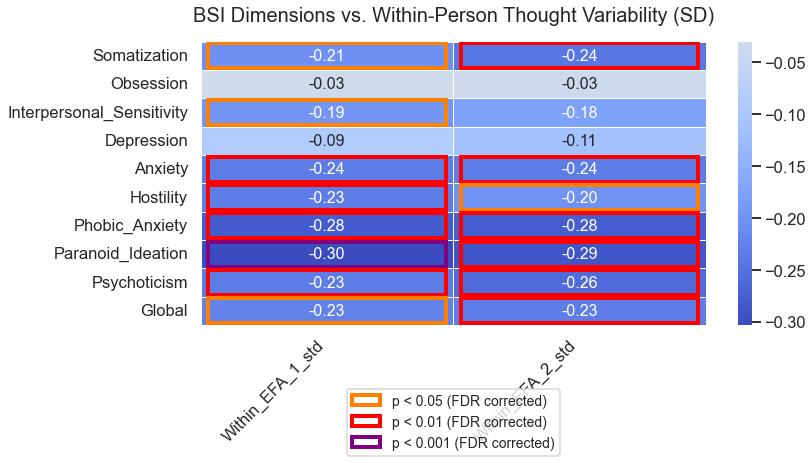

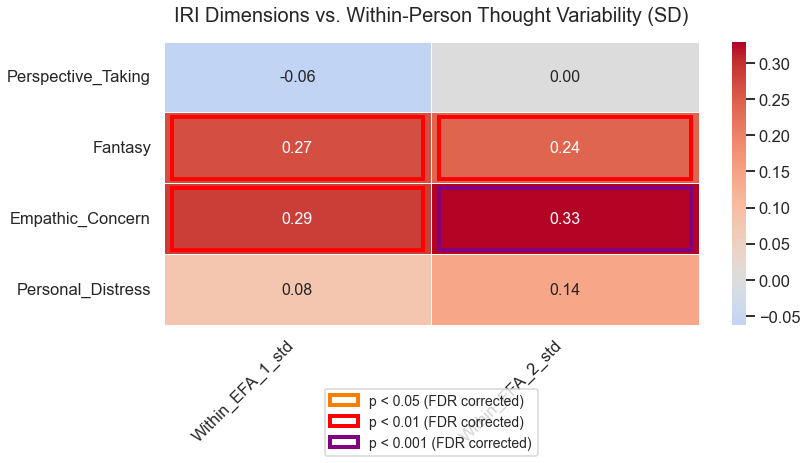

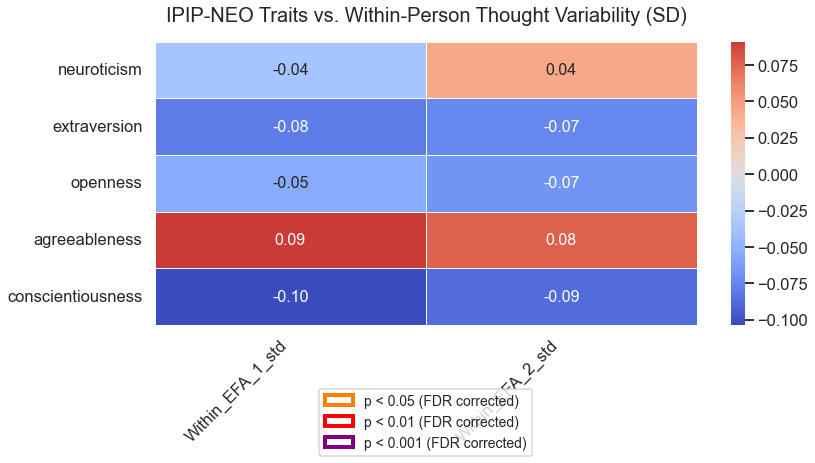

In [ ]:
import pandas as pd

# --- Trait Correlations with Thought Variability (Standard Deviation) ---
# This analysis explores whether stable personality traits are related to the
# amount of variability (volatility) in a person's thought patterns over time.

print("\n" + "="*20 + " TRAIT vs. THOUGHT VARIABILITY ANALYSIS " + "="*20)

# 1. Calculate the variability (standard deviation) of within-person factor scores for each participant.
# 'within_factor_scores_obs_df' has the scores for each episode.
# We need to add the participant ID to it first.
within_scores_with_id = within_factor_scores_obs_df.join(tcqData['expiwellID'], how='inner')

# Now, group by participant and calculate the standard deviation for each factor.
participant_thought_variability = within_scores_with_id.groupby('expiwellID')[within_efa_cols].std()

# Rename columns to indicate they represent standard deviation.
participant_thought_variability.columns = [f'{col}_std' for col in participant_thought_variability.columns]

print("Calculated the standard deviation of within-person EFA scores for each participant.")
display(participant_thought_variability.head())


# 2. Prepare the analysis DataFrame
# Merge the variability data with the questionnaire data.
variability_analysis_df = pd.merge(
    participant_thought_variability,
    postQDat[all_questionnaire_cols],
    left_index=True,
    right_index=True,
    how='inner'
)

# 3. Run Correlation Analysis
# We can reuse the 'run_correlation_analysis' function.
# The x-variables are the standard deviations of the within-person EFA factors.
# The y-variables are the trait scores.

# BSI Dimensions vs. Thought Variability
run_correlation_analysis(
    df=variability_analysis_df,
    x_cols=participant_thought_variability.columns,
    y_cols=bsi_score_cols,
    title='BSI Dimensions vs. Within-Person Thought Variability (SD)'
)

# IRI Dimensions vs. Thought Variability
run_correlation_analysis(
    df=variability_analysis_df,
    x_cols=participant_thought_variability.columns,
    y_cols=iri_cols,
    title='IRI Dimensions vs. Within-Person Thought Variability (SD)'
)

# IPIP-NEO Traits vs. Thought Variability
run_correlation_analysis(
    df=variability_analysis_df,
    x_cols=participant_thought_variability.columns,
    y_cols=ipip_cols,
    title='IPIP-NEO Traits vs. Within-Person Thought Variability (SD)'
)

PCA will be performed on 130 participants across 49 raw BSI items.

Bartlett's test of sphericity: χ² = 4891.4, p-value = 0
-> Suggests that correlations are sufficiently large for PCA.

Kaiser-Meyer-Olkin (KMO) measure: 0.90
-> Sampling adequacy is meritorious/marvelous.

Kaiser criterion (eigenvalues > 1) suggests retaining 10 component(s).


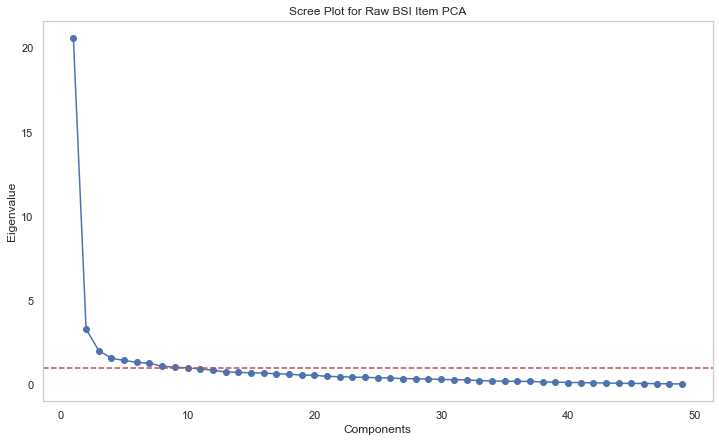


--- Rotated Component Loadings for Raw BSI Data (Varimax) ---
Showing loadings > 0.4 for clarity.


,BSI Raw Comp 1,BSI Raw Comp 2,BSI Raw Comp 3,BSI Raw Comp 4,BSI Raw Comp 5,BSI Raw Comp 6,BSI Raw Comp 7,BSI Raw Comp 8,BSI Raw Comp 9,BSI Raw Comp 10
BSI_2,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.71
BSI_7,0.49,nan,nan,nan,nan,nan,nan,nan,nan,nan
BSI_23,0.45,nan,nan,nan,nan,0.51,nan,nan,nan,nan
BSI_29,nan,nan,0.62,nan,nan,nan,nan,nan,nan,nan
BSI_30,nan,nan,0.41,nan,nan,nan,nan,nan,nan,0.50
BSI_33,0.43,nan,0.44,nan,nan,nan,nan,nan,nan,nan
BSI_37,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.55
BSI_5,nan,0.77,nan,nan,nan,nan,nan,nan,nan,nan
BSI_15,nan,0.53,nan,nan,nan,0.55,nan,nan,nan,nan
BSI_26,nan,0.67,nan,nan,nan,nan,nan,nan,nan,nan



--- Variance Explained by Each Raw BSI Component ---


,SS Loadings,% of Variance,Cumulative %
BSI Raw Comp 1,638.80%,13.04%,13.04%
BSI Raw Comp 2,475.41%,9.70%,22.74%
BSI Raw Comp 3,533.16%,10.88%,33.62%
BSI Raw Comp 4,236.54%,4.83%,38.45%
BSI Raw Comp 5,314.01%,6.41%,44.86%
BSI Raw Comp 6,364.35%,7.44%,52.29%
BSI Raw Comp 7,243.89%,4.98%,57.27%
BSI Raw Comp 8,280.10%,5.72%,62.98%
BSI Raw Comp 9,150.85%,3.08%,66.06%
BSI Raw Comp 10,236.96%,4.84%,70.90%


Total variance explained by 10 component(s): 70.90%

--- Latent Raw BSI Component Scores (first 5 participants) ---
These scores have been added to the 'postQDat' DataFrame for future analyses.


,BSI_Raw_Comp_1,BSI_Raw_Comp_2,BSI_Raw_Comp_3,BSI_Raw_Comp_4,BSI_Raw_Comp_5,BSI_Raw_Comp_6,BSI_Raw_Comp_7,BSI_Raw_Comp_8,BSI_Raw_Comp_9,BSI_Raw_Comp_10
EID,,,,,,,,,,
662c23eb984be5dc85b1f907,1.211016,0.648407,0.528462,0.955822,0.271777,-0.631055,0.349947,0.388666,0.088433,-0.257573
662c1a3e984be5dc85b1ac7c,0.444998,0.390947,-0.104783,0.483795,-0.338861,0.773893,-0.773727,-0.236029,-0.111684,-1.049353
663413e56d0b687e4df00efd,-0.465670,-0.926589,0.027313,-0.033452,-0.213658,-0.764886,-0.628873,-0.339500,-0.078848,-0.298791
6633d9a6d05d24da8bf2f215,-0.749270,0.322961,-1.111389,0.424845,0.832637,2.527795,-0.500017,1.887659,0.307808,-0.104209
66394fd7442523ed8761623e,1.928852,-1.383781,0.115635,1.888195,-1.999968,2.275831,-2.869800,1.825737,-1.263176,0.498745


In [ ]:
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Prepare the data
# Define the specific BSI items to be included in the PCA, based on the 9 dimensions.
bsi_items_for_pca = [
    # Somatization
    'BSI_2', 'BSI_7', 'BSI_23', 'BSI_29', 'BSI_30', 'BSI_33', 'BSI_37',
    # Obsession-Compulsion
    'BSI_5', 'BSI_15', 'BSI_26', 'BSI_27', 'BSI_32', 'BSI_36',
    # Interpersonal Sensitivity
    'BSI_20', 'BSI_21', 'BSI_22', 'BSI_42',
    # Depression
    'BSI_9', 'BSI_16', 'BSI_17', 'BSI_18', 'BSI_35', 'BSI_50',
    # Anxiety
    'BSI_1', 'BSI_12', 'BSI_19', 'BSI_38', 'BSI_45', 'BSI_49',
    # Hostility
    'BSI_6', 'BSI_13', 'BSI_40', 'BSI_41', 'BSI_46',
    # Phobic Anxiety
    'BSI_8', 'BSI_28', 'BSI_31', 'BSI_43', 'BSI_47',
    # Paranoid Ideation
    'BSI_4', 'BSI_10', 'BSI_24', 'BSI_48', 'BSI_51',
    # Psychoticism
    'BSI_3', 'BSI_14', 'BSI_34', 'BSI_44', 'BSI_53'
]

# Select only the columns that exist in the postQDat dataframe
existing_raw_bsi_cols = [col for col in bsi_items_for_pca if col in postQDat.columns]

# Ensure all data is numeric, coercing errors, then drop rows with any missing BSI data
bsi_pca_data_raw = postQDat[existing_raw_bsi_cols].apply(pd.to_numeric, errors='coerce').dropna()

print(f"PCA will be performed on {bsi_pca_data_raw.shape[0]} participants across {bsi_pca_data_raw.shape[1]} raw BSI items.")

# 2. Z-score the data
scaler = StandardScaler()
bsi_pca_zscored_raw = pd.DataFrame(scaler.fit_transform(bsi_pca_data_raw), 
                                   index=bsi_pca_data_raw.index, 
                                   columns=bsi_pca_data_raw.columns)

# 3. Assess Suitability for PCA
# Bartlett's test of sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(bsi_pca_zscored_raw)
print(f"\nBartlett's test of sphericity: χ² = {chi_square_value:.1f}, p-value = {p_value:.3g}")
if p_value < 0.05:
    print("-> Suggests that correlations are sufficiently large for PCA.")
else:
    print("-> The test was not significant. PCA may not be appropriate.")

# Kaiser-Meyer-Olkin (KMO) measure of sampling adequacy
kmo_per_variable, kmo_total = calculate_kmo(bsi_pca_zscored_raw)
print(f"\nKaiser-Meyer-Olkin (KMO) measure: {kmo_total:.2f}")
if kmo_total >= 0.8:
    print("-> Sampling adequacy is meritorious/marvelous.")
else:
    print("-> Sampling adequacy is mediocre or worse.")

# 4. Perform PCA with Varimax Rotation
# Determine the number of factors to retain using eigenvalues > 1
fa_bsi_raw = FactorAnalyzer(rotation=None, method='principal')
fa_bsi_raw.fit(bsi_pca_zscored_raw)
ev, v = fa_bsi_raw.get_eigenvalues()
n_bsi_factors_raw = sum(ev > 1)
print(f"\nKaiser criterion (eigenvalues > 1) suggests retaining {n_bsi_factors_raw} component(s).")

# Plot Scree Plot
plt.figure(figsize=(12, 7))
plt.scatter(range(1, bsi_pca_zscored_raw.shape[1] + 1), ev)
plt.plot(range(1, bsi_pca_zscored_raw.shape[1] + 1), ev)
plt.title('Scree Plot for Raw BSI Item PCA')
plt.xlabel('Components')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.grid()
plt.show()

# Rerun the analysis with the determined number of factors and Varimax rotation
fa_bsi_rotated_raw = FactorAnalyzer(n_factors=n_bsi_factors_raw, rotation='varimax', method='principal')
fa_bsi_rotated_raw.fit(bsi_pca_zscored_raw)

# 5. Examine and Display Results
# Component Loadings
bsi_loadings_raw_df = pd.DataFrame(fa_bsi_rotated_raw.loadings_, 
                                   index=bsi_pca_zscored_raw.columns,
                                   columns=[f'BSI Raw Comp {i+1}' for i in range(n_bsi_factors_raw)])

print("\n--- Rotated Component Loadings for Raw BSI Data (Varimax) ---")
print("Showing loadings > 0.4 for clarity.")
display(bsi_loadings_raw_df[abs(bsi_loadings_raw_df) > 0.4].style.format('{:.2f}'))

# Variance Explained
variance, prop_var, cum_var = fa_bsi_rotated_raw.get_factor_variance()
bsi_variance_raw_df = pd.DataFrame({
    'SS Loadings': variance,
    '% of Variance': prop_var,
    'Cumulative %': cum_var
}, index=[f'BSI Raw Comp {i+1}' for i in range(n_bsi_factors_raw)])

print("\n--- Variance Explained by Each Raw BSI Component ---")
total_variance_explained = bsi_variance_raw_df['% of Variance'].sum() * 100
display((bsi_variance_raw_df * 100).style.format('{:.2f}%'))
print(f"Total variance explained by {n_bsi_factors_raw} component(s): {total_variance_explained:.2f}%")

# 6. Store the resulting component scores for later use
bsi_component_scores_raw = fa_bsi_rotated_raw.transform(bsi_pca_zscored_raw)
bsi_component_scores_raw_df = pd.DataFrame(bsi_component_scores_raw, 
                                           index=bsi_pca_zscored_raw.index,
                                           columns=[f'BSI_Raw_Comp_{i+1}' for i in range(n_bsi_factors_raw)])

# Add these new component scores to the main post-survey dataframe
postQDat = postQDat.join(bsi_component_scores_raw_df)

print("\n--- Latent Raw BSI Component Scores (first 5 participants) ---")
print("These scores have been added to the 'postQDat' DataFrame for future analyses.")
display(postQDat[bsi_component_scores_raw_df.columns].head())


==================== INTERPRETING BSI PCA COMPONENTS ====================

--- Analysis of BSI Raw Comp 1 ---
Top contributing original dimensions (based on 6 items with |loading| >= 0.5):
Anxiety           3
Phobic_Anxiety    3
dtype: int64

--- Analysis of BSI Raw Comp 2 ---
Top contributing original dimensions (based on 6 items with |loading| >= 0.5):
Obsession    6
dtype: int64

--- Analysis of BSI Raw Comp 3 ---
Top contributing original dimensions (based on 6 items with |loading| >= 0.5):
Hostility         2
Somatization      1
Depression        1
Phobic_Anxiety    1
Psychoticism      1
dtype: int64

--- Analysis of BSI Raw Comp 4 ---
Top contributing original dimensions (based on 2 items with |loading| >= 0.5):
Depression      1
Psychoticism    1
dtype: int64

--- Analysis of BSI Raw Comp 5 ---
Top contributing original dimensions (based on 4 items with |loading| >= 0.5):
Hostility                    2
Interpersonal_Sensitivity    1
Paranoid_Ideation            1
dtype: int64



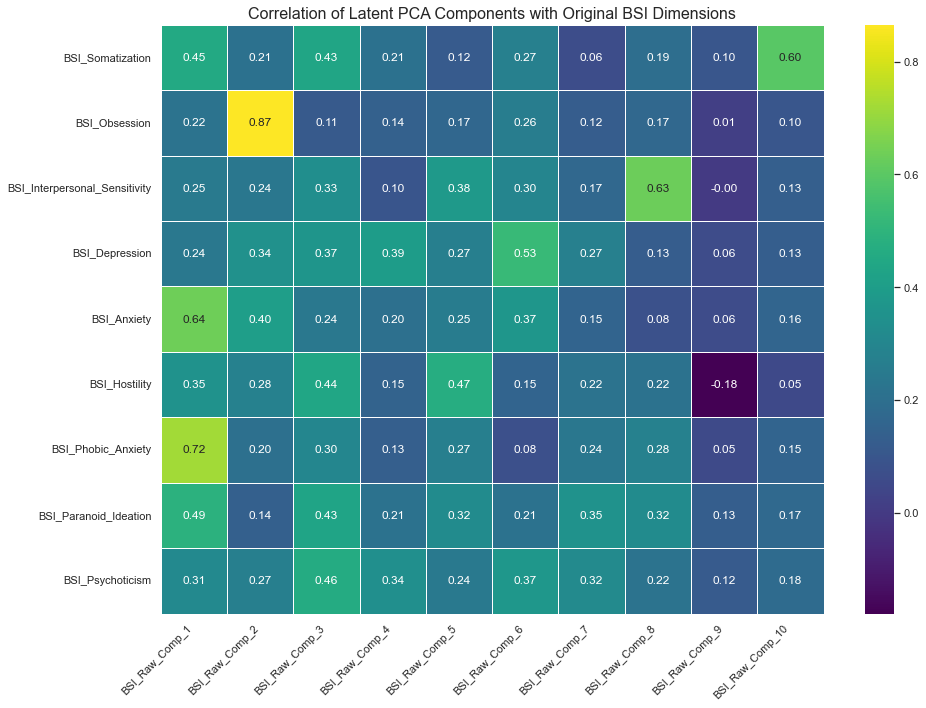

In [ ]:

# --- 7. Interpret PCA Components using Original BSI Dimensions ---
print("\n" + "="*20 + " INTERPRETING BSI PCA COMPONENTS " + "="*20)

# Define the original BSI dimension mappings to interpret the components
bsi_dimensions_map = {
    'Somatization': ['BSI_2', 'BSI_7', 'BSI_23', 'BSI_29', 'BSI_30', 'BSI_33', 'BSI_37'], 
    'Obsession': ['BSI_5', 'BSI_15', 'BSI_26', 'BSI_27', 'BSI_32', 'BSI_36'], 
    'Interpersonal_Sensitivity': ['BSI_20', 'BSI_21', 'BSI_22', 'BSI_42'], 
    'Depression': ['BSI_9', 'BSI_16', 'BSI_17', 'BSI_18', 'BSI_35', 'BSI_50'], 
    'Anxiety': ['BSI_1', 'BSI_12', 'BSI_19', 'BSI_38', 'BSI_45', 'BSI_49'], 
    'Hostility': ['BSI_6', 'BSI_13', 'BSI_40',  'BSI_41','BSI_46'], 
    'Phobic_Anxiety': ['BSI_8', 'BSI_28', 'BSI_31', 'BSI_43', 'BSI_47'],
    'Paranoid_Ideation': ['BSI_4', 'BSI_10', 'BSI_24', 'BSI_48', 'BSI_51'],
    'Psychoticism': ['BSI_3', 'BSI_14', 'BSI_34', 'BSI_44', 'BSI_53']
}
# Create a reverse mapping from item to dimension
item_to_dimension_map = {item: dim for dim, items in bsi_dimensions_map.items() for item in items}

# Analyze the composition of each new component
LOADING_THRESHOLD = 0.5 # Consider items with loading > 0.5
for component in bsi_loadings_raw_df.columns:
    print(f"\n--- Analysis of {component} ---")
    
    # Get items that load strongly on this component
    strong_loaders = bsi_loadings_raw_df[component][abs(bsi_loadings_raw_df[component]) >= LOADING_THRESHOLD].index.tolist()
    
    if not strong_loaders:
        print(f"No items loaded above {LOADING_THRESHOLD} for this component.")
        continue
        
    # Count how many of these items come from each original BSI dimension
    dimension_counts = pd.Series([item_to_dimension_map.get(item, 'Unknown') for item in strong_loaders]).value_counts()
    
    print(f"Top contributing original dimensions (based on {len(strong_loaders)} items with |loading| >= {LOADING_THRESHOLD}):")
    print(dimension_counts)


# --- 8. Correlate PCA Components with Original BSI Dimension Scores ---
print("\n" + "="*20 + " CORRELATION WITH BSI DIMENSIONS " + "="*20)
print("Correlating the new latent PCA components with the original 9 BSI dimension scores.")

# Define the original BSI dimension score columns
original_bsi_score_cols = [f'BSI_{dim}' for dim in bsi_dimensions_map.keys()]

# Select the new component score columns
new_bsi_component_cols = bsi_component_scores_raw_df.columns.tolist()

# Combine for correlation analysis
correlation_data = postQDat[original_bsi_score_cols + new_bsi_component_cols]
bsi_corr_matrix = correlation_data.corr()

# We are only interested in the correlation between the old and new sets of scores
bsi_cross_corr = bsi_corr_matrix.loc[original_bsi_score_cols, new_bsi_component_cols]

# Visualize the cross-correlation matrix as a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    bsi_cross_corr,
    annot=True,
    fmt=".2f",
    cmap='viridis',
    linewidths=.5,
    annot_kws={"size": 12}
)
plt.title('Correlation of Latent PCA Components with Original BSI Dimensions', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

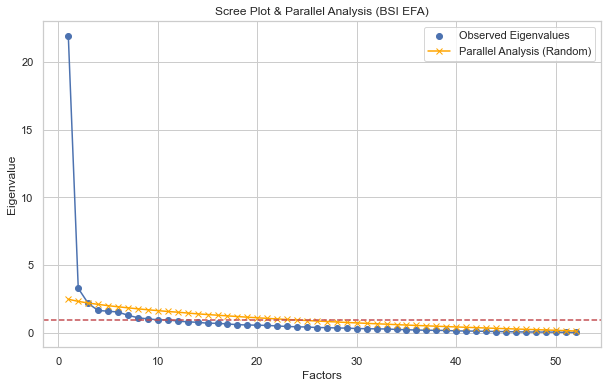

Suggested number of factors (Observed > Parallel): 2


In [ ]:
from factor_analyzer import FactorAnalyzer
import numpy as np
import matplotlib.pyplot as plt

# --- Parallel Analysis for EFA on BSI Data ---
bsi_global_cols = [f'BSI_{i}' for i in range(1, 54) if i != 46]
# 1. Prepare BSI data (numeric, complete cases)
bsi_items_df = postQDat[bsi_global_cols].apply(pd.to_numeric, errors='coerce').dropna()

# 2. Run observed EFA (no rotation, max factors)
fa_bsi = FactorAnalyzer(n_factors=bsi_items_df.shape[1], rotation=None)
fa_bsi.fit(bsi_items_df)
ev_bsi, _ = fa_bsi.get_eigenvalues()

# 3. Parallel analysis: simulate random data and get mean eigenvalues
def run_parallel_analysis(data, n_iter=100, random_state=42):
    n_obs, n_vars = data.shape
    rng = np.random.default_rng(random_state)
    rand_eigs = np.zeros((n_iter, n_vars))
    for i in range(n_iter):
        rand_data = rng.normal(size=(n_obs, n_vars))
        fa_rand = FactorAnalyzer(n_factors=n_vars, rotation=None)
        fa_rand.fit(rand_data)
        rand_eigs[i, :] = fa_rand.get_eigenvalues()[0]
    mean_rand_eigs = rand_eigs.mean(axis=0)
    return mean_rand_eigs

mean_rand_eigs_bsi = run_parallel_analysis(bsi_items_df)

# 4. Plot observed vs. parallel eigenvalues (scree plot)
plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(ev_bsi) + 1), ev_bsi, label='Observed Eigenvalues')
plt.plot(range(1, len(ev_bsi) + 1), ev_bsi)
plt.plot(range(1, len(ev_bsi) + 1), mean_rand_eigs_bsi, color='orange', marker='x', label='Parallel Analysis (Random)')
plt.title('Scree Plot & Parallel Analysis (BSI EFA)')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

print(f"Suggested number of factors (Observed > Parallel): {(ev_bsi > mean_rand_eigs_bsi).sum()}")

Shape of the BSI data for EFA: (130, 52)
Number of participants with complete BSI data: 130

Kaiser-Meyer-Olkin (KMO) Test: 0.893
KMO value is acceptable (> 0.6).

Bartlett's Test of Sphericity: chi-square = 5342.94, p-value = 0.000
Bartlett's test is significant (p < 0.05), which is good.


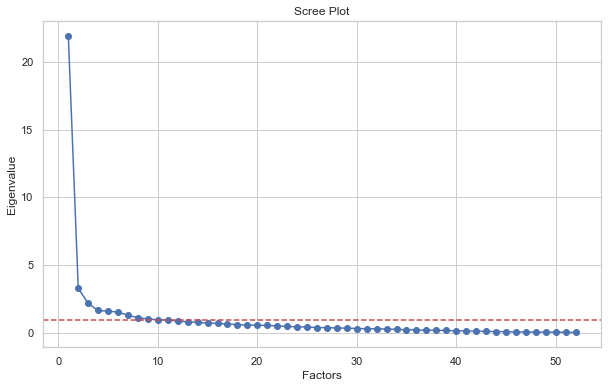


Factor Loadings for 2 factors (Promax Rotation):


,Factor 1,Factor 2
BSI_1,0.030510,0.555389
BSI_2,0.521081,0.020030
BSI_3,0.780325,-0.217527
BSI_4,0.638414,0.011092
BSI_5,-0.141574,0.727654
BSI_6,-0.095342,0.674954
BSI_7,0.711022,0.020953
BSI_8,0.754525,0.046989
BSI_9,0.792553,-0.136490
BSI_10,0.625906,0.086071


In [ ]:

# EFA on BSI
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# 1. Select BSI data
# Assuming 'bsi_cols' contains the names of the BSI item columns
# and 'postQDat' is the dataframe containing this data.

# --- FIX: Convert BSI item columns to numeric before analysis ---
# The error occurs because the columns contain non-numeric data (likely strings).
# We need to convert them to a numeric type first.
bsi_items_df = postQDat[bsi_global_cols].apply(pd.to_numeric, errors='coerce').dropna()


print(f"Shape of the BSI data for EFA: {bsi_items_df.shape}")
print(f"Number of participants with complete BSI data: {bsi_items_df.shape[0]}")

# 2. Assess data adequacy for EFA
# KMO Test
kmo_all, kmo_model = calculate_kmo(bsi_items_df)
print(f"\nKaiser-Meyer-Olkin (KMO) Test: {kmo_model:.3f}")
if kmo_model < 0.6:
    print("KMO value is less than 0.6, which is not ideal. The data may not be very suitable for factor analysis.")
else:
    print("KMO value is acceptable (> 0.6).")

# Bartlett's Test
chi_square_value, p_value = calculate_bartlett_sphericity(bsi_items_df)
print(f"\nBartlett's Test of Sphericity: chi-square = {chi_square_value:.2f}, p-value = {p_value:.3f}")
if p_value > 0.05:
    print("Bartlett's test is not significant (p > 0.05). The correlation matrix may be an identity matrix, which is not suitable for EFA.")
else:
    print("Bartlett's test is significant (p < 0.05), which is good.")

# 3. Perform EFA and create Scree Plot
fa = FactorAnalyzer(n_factors=25, rotation=None) # Start with a large number of factors
fa.fit(bsi_items_df)
ev, v = fa.get_eigenvalues()

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.scatter(range(1, bsi_items_df.shape[1] + 1), ev)
plt.plot(range(1, bsi_items_df.shape[1] + 1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.show()

# 4. Run EFA with a chosen number of factors (e.g., based on scree plot)
# Let's choose 9 factors based on the original BSI structure and eigenvalues > 1
n_factors_chosen = 2
fa = FactorAnalyzer(n_factors=n_factors_chosen, rotation="promax")
fa.fit(bsi_items_df)

# Get factor loadings
loadings_df = pd.DataFrame(fa.loadings_, index=bsi_items_df.columns, columns=[f'Factor {i+1}' for i in range(n_factors_chosen)])

# Display loadings
print(f"\nFactor Loadings for {n_factors_chosen} factors (Promax Rotation):")
display(loadings_df.style.apply(lambda x: ['background: lightgreen' if abs(val) > 0.4 else '' for val in x], axis=1))



--- BSI EFA Factor Scores (first 5 participants) ---
These scores have been added to the 'postQDat' DataFrame.


,BSI_EFA_Factor_1,BSI_EFA_Factor_2
EID,,
662c23eb984be5dc85b1f907,1.430809,0.983123
662c1a3e984be5dc85b1ac7c,-0.122396,0.381504
663413e56d0b687e4df00efd,-0.863516,-1.334360
6633d9a6d05d24da8bf2f215,0.127830,1.535695
66394fd7442523ed8761623e,1.057181,0.862092


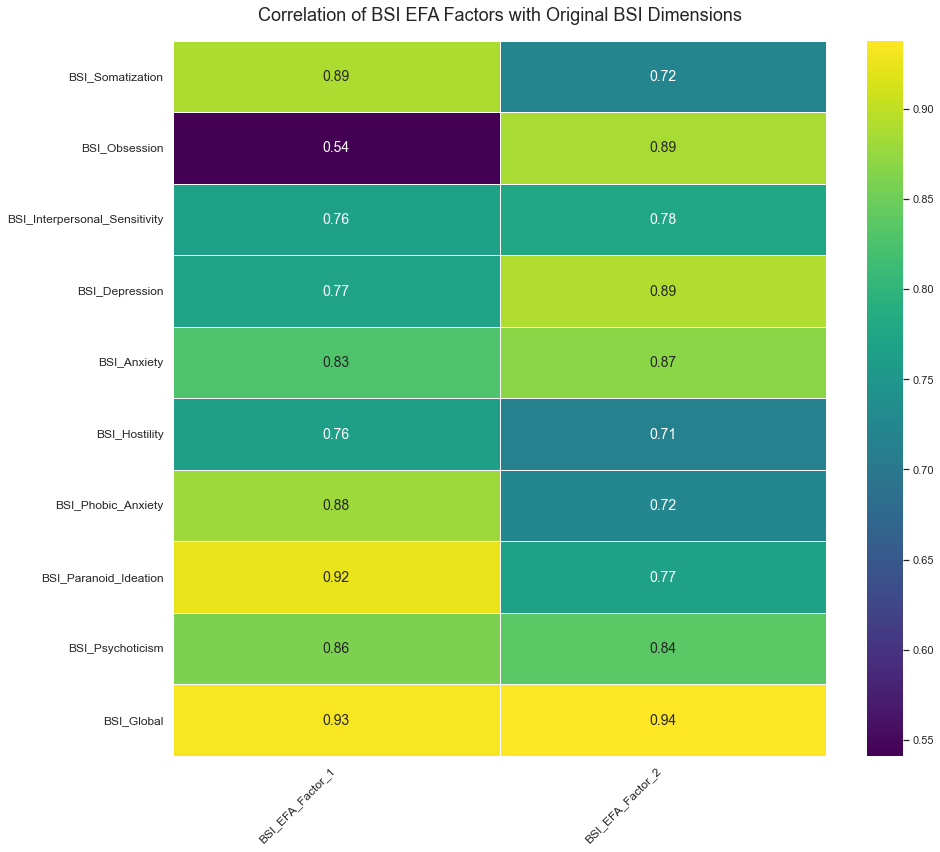

In [ ]:

# 5. Get factor scores and add them to the main dataframe
# Use the 'transform' method on the fitted factor analyzer object
bsi_factor_scores = fa.transform(bsi_items_df)

# Create a new dataframe for these scores
bsi_factor_scores_df = pd.DataFrame(
    bsi_factor_scores,
    index=bsi_items_df.index,
    columns=[f'BSI_EFA_Factor_{i+1}' for i in range(n_factors_chosen)]
)

# Join these new factor scores with the main postQDat dataframe
postQDat = postQDat.join(bsi_factor_scores_df)

print("\n--- BSI EFA Factor Scores (first 5 participants) ---")
print("These scores have been added to the 'postQDat' DataFrame.")
display(postQDat[bsi_factor_scores_df.columns].head())


# 6. Correlate new EFA factors with original BSI dimension scores
# Define the columns for correlation
new_bsi_factors = bsi_factor_scores_df.columns.tolist()

# Calculate the correlation matrix between the two sets of scores
correlation_matrix_bsi_efa = postQDat[new_bsi_factors + bsi_score_cols].corr()

# We only want to see the cross-correlations
cross_corr_bsi = correlation_matrix_bsi_efa.loc[bsi_score_cols, new_bsi_factors]

# 7. Visualize the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(
    cross_corr_bsi,
    annot=True,
    fmt=".2f",
    cmap='viridis',
    linewidths=.5,
    annot_kws={"size": 14}
)
plt.title('Correlation of BSI EFA Factors with Original BSI Dimensions', fontsize=18, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

==================== BETWEEN-PERSON EFA (WEIGHTED) ====================
Analyzing the structure of stable, individual differences, weighted by number of episodes.

Data for Between-Person EFA has 127 participants (after filtering for >= 2 episodes).

Weighted Between-Person Correlation Matrix (Top 5 rows):


,visImag,inSpeech,intent,struct,real,concAbs,import,relGoal,oftMind,emotVal
visImag,1.000000,0.200799,0.395841,0.394721,0.208567,0.267081,0.346678,0.366608,0.270296,0.427319
inSpeech,0.200799,1.000000,0.122206,0.227627,0.303423,0.190249,0.288249,0.239980,0.377221,0.189572
intent,0.395841,0.122206,1.000000,0.486286,0.197433,0.187953,0.266174,0.399999,0.305442,0.371901
struct,0.394721,0.227627,0.486286,1.000000,0.323795,0.304189,0.529894,0.615392,0.579933,0.496908
real,0.208567,0.303423,0.197433,0.323795,1.000000,0.842434,0.632193,0.286018,0.160309,0.280617


KMO Test for Between-Person Data: 0.771
Bartlett's Test: chi-square = 513.31, p-value = 9.93e-81


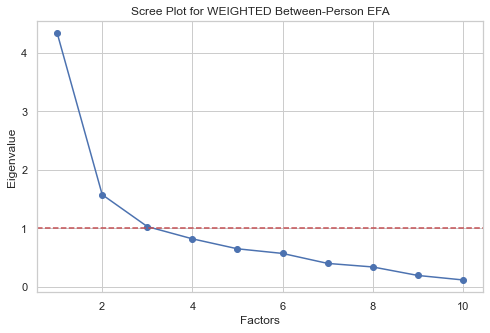


Scree plot suggests retaining 3 factors for the weighted between-person analysis.

--- WEIGHTED Between-Person Factor Loadings (Promax Rotation) ---


,Between Factor 1,Between Factor 2,Between Factor 3
visImag,-0.038720,0.058393,0.613957
inSpeech,0.369363,0.119493,-0.056604
intent,-0.056498,-0.041586,0.707935
struct,0.393547,-0.009878,0.475204
real,0.069016,0.929248,-0.073491
concAbs,-0.232083,0.971802,0.133590
import,0.635001,0.389472,-0.033236
relGoal,0.723684,-0.136066,0.183109
oftMind,0.931276,-0.234450,-0.014433
emotVal,0.153176,0.067284,0.495683



--- Variance Explained by Each Factor (Weighted Between-Person) ---


,SS Loadings,% of Variance,Cumulative %
Between Factor 1,2.172,21.72%,21.72%
Between Factor 2,2.057,20.57%,42.29%
Between Factor 3,1.411,14.11%,56.40%


In [ ]:
#weighted by number of observations per participant

tcq_cols = ['visImag', 'inSpeech', 'intent', 'struct', 'real', 'concAbs', 'import', 'relGoal','oftMind', 'emotVal',]
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo

# --- 1. Between-Person EFA (Weighted) ---
print("="*20 + " BETWEEN-PERSON EFA (WEIGHTED) " + "="*20)
print("Analyzing the structure of stable, individual differences, weighted by number of episodes.")

# Prepare data
between_efa_data_full = between[tcq_cols].dropna()

# Get the number of episodes for each participant to use as weights
episode_counts = tcqData.groupby('expiwellID').size()

# Filter for participants with at least 2 episodes
episode_counts_filtered = episode_counts[episode_counts >= 2]

# Find the common participants between the data and the valid weights
common_participants = between_efa_data_full.index.intersection(episode_counts_filtered.index)

# Filter both the data and the weights to the common set of participants
between_efa_data = between_efa_data_full.loc[common_participants]
weights = episode_counts_filtered.loc[common_participants]


print(f"\nData for Between-Person EFA has {between_efa_data.shape[0]} participants (after filtering for >= 2 episodes).")

# Calculate the weighted correlation matrix
X_for_cov = between_efa_data.to_numpy()
w_for_cov = weights.to_numpy()


# np.cov with aweights gives weighted covariance. Convert to correlation.
weighted_cov_matrix = np.cov(X_for_cov, rowvar=False, aweights=w_for_cov)
d = np.sqrt(np.diag(weighted_cov_matrix))
# Handle potential division by zero if a variable has zero variance
d[d == 0] = 1
weighted_corr_matrix = (weighted_cov_matrix / np.outer(d, d))
weighted_corr_df = pd.DataFrame(weighted_corr_matrix, index=between_efa_data.columns, columns=between_efa_data.columns)

print("\nWeighted Between-Person Correlation Matrix (Top 5 rows):")
display(weighted_corr_df.head())

# Assess data adequacy (using the unweighted data for standard tests)
kmo_all, kmo_model = calculate_kmo(between_efa_data)
print(f"KMO Test for Between-Person Data: {kmo_model:.3f}")
chi_square_value, p_value = calculate_bartlett_sphericity(between_efa_data)
print(f"Bartlett's Test: chi-square = {chi_square_value:.2f}, p-value = {p_value:.3g}")

# Determine number of factors from the WEIGHTED correlation matrix
# The number of observations is needed when fitting from a correlation matrix
n_obs = len(between_efa_data)
fa_between_scree = FactorAnalyzer(n_factors=between_efa_data.shape[1], rotation=None, is_corr_matrix=True)
fa_between_scree.fit(weighted_corr_df)
ev_b, v_b = fa_between_scree.get_eigenvalues()
n_factors_between = sum(ev_b > 1)

plt.figure(figsize=(8, 5))
plt.scatter(range(1, between_efa_data.shape[1] + 1), ev_b)
plt.plot(range(1, between_efa_data.shape[1] + 1), ev_b)
plt.title('Scree Plot for WEIGHTED Between-Person EFA')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.grid(True)
plt.show()

print(f"\nScree plot suggests retaining {n_factors_between} factors for the weighted between-person analysis.")

# Run the EFA with Promax rotation on the weighted correlation matrix
fa_between = FactorAnalyzer(n_factors=n_factors_between, rotation="promax",is_corr_matrix=True)
fa_between.fit(weighted_corr_df)

# Display loadings
between_loadings_df = pd.DataFrame(
    fa_between.loadings_, 
    index=between_efa_data.columns, 
    columns=[f'Between Factor {i+1}' for i in range(n_factors_between)]
)
print("\n--- WEIGHTED Between-Person Factor Loadings (Promax Rotation) ---")
display(between_loadings_df.style.apply(lambda x: ['background: lightgreen' if abs(val) > 0.4 else '' for val in x], axis=1))


# Get and display the variance explained by each factor
variance, proportional_variance, cumulative_variance = fa_between.get_factor_variance()
variance_df = pd.DataFrame({
    'SS Loadings': variance,
    '% of Variance': proportional_variance,
    'Cumulative %': cumulative_variance
}, index=[f'Between Factor {i+1}' for i in range(n_factors_between)])

print("\n--- Variance Explained by Each Factor (Weighted Between-Person) ---")
# Multiply by 100 to show as percentage
display((variance_df).style.format({'SS Loadings': '{:.3f}', '% of Variance': '{:.2%}', 'Cumulative %': '{:.2%}'}))



In [ ]:
#This was for the raw EFA data I believe
""" from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- Exploratory Factor Analysis (EFA) on TCQ Data RAW EPISODES---

# 1. Select and prepare the data
# We will use the per-episode data from tcqData to analyze the structure of thoughts.
tcq_cols_efa = [
    'Participant ID','visImag', 'inSpeech', 'intent', 'struct', 'real', 'concAbs', 
    'import', 'relGoal', 'fullDev', 'oftMind', 'emotVal'
]
# Drop rows with any missing values in these columns
tcq_efa_df = tcqData[tcq_cols_efa].dropna()
#tcq_efa_df[tcq_cols] = tcq_efa_df.groupby("Participant ID")[tcq_cols].transform(lambda x: x - x.mean())
tcq_efa_df = tcq_efa_df.drop(columns=['Participant ID'])

print(f"Shape of the TCQ data for EFA: {tcq_efa_df.shape}")
print(f"Number of thought samples with complete TCQ data: {tcq_efa_df.shape[0]}")

# 2. Assess data adequacy for EFA
# KMO Test
kmo_all, kmo_model = calculate_kmo(tcq_efa_df)
print(f"\nKaiser-Meyer-Olkin (KMO) Test: {kmo_model:.3f}")
if kmo_model < 0.7:
    print("KMO value is less than 0.7. The data may not be ideal for factor analysis.")
else:
    print("KMO value is acceptable (> 0.7).")

# Bartlett's Test
chi_square_value, p_value = calculate_bartlett_sphericity(tcq_efa_df)
print(f"\nBartlett's Test of Sphericity: chi-square = {chi_square_value:.2f}, p-value = {p_value:.3g}")
if p_value > 0.05:
    print("Bartlett's test is not significant (p > 0.05), which is not suitable for EFA.")
else:
    print("Bartlett's test is significant (p < 0.05), which is good.")

# 3. Perform EFA and create Scree Plot to determine the number of factors
# Start with a large number of factors to see all eigenvalues
fa_scree = FactorAnalyzer(n_factors=tcq_efa_df.shape[1], rotation=None)
fa_scree.fit(tcq_efa_df)
ev, v = fa_scree.get_eigenvalues()

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.scatter(range(1, tcq_efa_df.shape[1] + 1), ev)
plt.plot(range(1, tcq_efa_df.shape[1] + 1), ev)
plt.title('Scree Plot for TCQ EFA')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.grid(True)
plt.show()

# 4. Run EFA with a chosen number of factors
# Based on the scree plot and the Kaiser criterion (eigenvalues > 1), let's choose 3 factors.
n_factors_chosen_tcq = sum(ev > 1)
print(f"\nBased on the scree plot, we will retain {n_factors_chosen_tcq} factors.")

fa_tcq = FactorAnalyzer(n_factors=n_factors_chosen_tcq, rotation="promax")
fa_tcq.fit(tcq_efa_df)

# Get factor loadings
tcq_loadings_df = pd.DataFrame(
    fa_tcq.loadings_, 
    index=tcq_efa_df.columns, 
    columns=[f'Factor {i+1}' for i in range(n_factors_chosen_tcq)]
)

# 5. Display loadings
print(f"\nFactor Loadings for {n_factors_chosen_tcq} factors (Promax Rotation):")
# Use the tcq_name_map for more descriptive row names if it exists
if 'tcq_name_map' in locals():
    display_loadings = tcq_loadings_df.rename(index=tcq_name_map)
else:
    display_loadings = tcq_loadings_df

display(display_loadings.style.apply(lambda x: ['background: lightgreen' if abs(val) > 0.4 else '' for val in x], axis=1)) """

""" # --- Correlate TCQ EFA Factor Scores with Questionnaire Data ---

# 1. Calculate TCQ EFA factor scores for each thought episode
# Use the 'fa_tcq' object from the previous EFA cell and the 'tcq_efa_df' data it was trained on.
tcq_efa_factor_scores_obs = fa_tcq.transform(tcq_efa_df)

# Create a DataFrame for these scores with descriptive names
tcq_efa_factor_scores_df = pd.DataFrame(
    tcq_efa_factor_scores_obs,
    index=tcq_efa_df.index,
    columns=[f'TCQ_EFA_Factor_{i+1}' for i in range(n_factors_chosen_tcq)]
)

# 2. Aggregate factor scores to the participant level
# Merge with tcqData to get the 'expiwellID' for grouping
scores_with_id = tcqData.join(tcq_efa_factor_scores_df, how='inner')

# Calculate the mean factor score for each participant
participant_efa_scores = scores_with_id.groupby('expiwellID')[tcq_efa_factor_scores_df.columns].mean()

# 3. Prepare the master analysis DataFrame
# Merge the participant-level EFA scores with the questionnaire data in postQDat
efa_analysis_df = participant_efa_scores.merge(
    postQDat[all_questionnaire_cols],
    left_index=True,
    right_index=True,
    how='inner'
)

# Define the new EFA factor columns
tcq_efa_cols = tcq_efa_factor_scores_df.columns.tolist()

# Ensure all columns for analysis are numeric
for col in tcq_efa_cols + all_questionnaire_cols:
    if col in efa_analysis_df.columns:
        efa_analysis_df[col] = pd.to_numeric(efa_analysis_df[col], errors='coerce')

print("\n--- Mean TCQ EFA Factor Scores per Participant (First 5) ---")
display(efa_analysis_df[tcq_efa_cols].head())


# 4. Run Correlation Analysis for Each Questionnaire vs. TCQ EFA Factors

# BSI vs. TCQ EFA Factors
run_correlation_analysis(
    df=efa_analysis_df, 
    x_cols=tcq_efa_cols, 
    y_cols=bsi_score_cols, 
    title='BSI Dimensions vs. TCQ EFA Factors'
)

# IRI vs. TCQ EFA Factors
run_correlation_analysis(
    df=efa_analysis_df, 
    x_cols=tcq_efa_cols, 
    y_cols=iri_cols, 
    title='IRI Dimensions vs. TCQ EFA Factors'
)

# IPIP-NEO vs. TCQ EFA Factors
run_correlation_analysis(
    df=efa_analysis_df, 
    x_cols=tcq_efa_cols, 
    y_cols=ipip_cols, 
    title='IPIP-NEO Traits vs. TCQ EFA Factors'
) """

' # --- Correlate TCQ EFA Factor Scores with Questionnaire Data ---\n\n# 1. Calculate TCQ EFA factor scores for each thought episode\n# Use the \'fa_tcq\' object from the previous EFA cell and the \'tcq_efa_df\' data it was trained on.\ntcq_efa_factor_scores_obs = fa_tcq.transform(tcq_efa_df)\n\n# Create a DataFrame for these scores with descriptive names\ntcq_efa_factor_scores_df = pd.DataFrame(\n    tcq_efa_factor_scores_obs,\n    index=tcq_efa_df.index,\n    columns=[f\'TCQ_EFA_Factor_{i+1}\' for i in range(n_factors_chosen_tcq)]\n)\n\n# 2. Aggregate factor scores to the participant level\n# Merge with tcqData to get the \'expiwellID\' for grouping\nscores_with_id = tcqData.join(tcq_efa_factor_scores_df, how=\'inner\')\n\n# Calculate the mean factor score for each participant\nparticipant_efa_scores = scores_with_id.groupby(\'expiwellID\')[tcq_efa_factor_scores_df.columns].mean()\n\n# 3. Prepare the master analysis DataFrame\n# Merge the participant-level EFA scores with the questio

In [ ]:
#RAW PCA 
""" 
from scipy.stats import zscore
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Thought Patterns in Daily Life (Principal Component Analysis) ---
# Methodology based on the provided paper.

# 1. Prepare the data
# Using all observations from tcqData, not participant averages.
tcq_cols_analysis = [
    'visImag', 'inSpeech', 'intent', 'struct', 'real', 'concAbs', 
    'import', 'relGoal', 'fullDev', 'oftMind', 'emotVal', 'tempOr'
]
# Use the main tcqData dataframe which contains all observations
pca_data_all_obs = tcqData[tcq_cols_analysis].dropna()

# Z-score the data before PCA, as per the paper's method
pca_data_zscored = pca_data_all_obs.apply(zscore)

print(f"PCA will be performed on {pca_data_zscored.shape[0]} observations across {pca_data_zscored.shape[1]} variables.")

# 2. Assess Suitability for PCA
# Bartlett's test of sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(pca_data_zscored)
print(f"\nBartlett's test of sphericity: χ² = {chi_square_value:.1f}, p-value = {p_value:.3g}")
if p_value < 0.05:
    print("-> Suggests that correlations are sufficiently large for PCA.")
else:
    print("-> The test was not significant. PCA may not be appropriate.")

# Kaiser-Meyer-Olkin (KMO) measure of sampling adequacy
kmo_per_variable, kmo_total = calculate_kmo(pca_data_zscored)
print(f"\nKaiser-Meyer-Olkin (KMO) measure: {kmo_total:.2f}")
if kmo_total >= 0.7:
    print("-> Sampling adequacy is good.")
elif kmo_total >= 0.6:
    print("-> Sampling adequacy is mediocre.")
else:
    print("-> Sampling adequacy is poor.")

# 3. Perform PCA with Varimax Rotation
# Create a FactorAnalyzer object
fa = FactorAnalyzer(rotation=None, method='principal')
fa.fit(pca_data_zscored)

# Get eigenvalues to determine the number of factors to retain
ev, v = fa.get_eigenvalues()
n_factors = sum(ev > 1)
print(f"\nKaiser criterion (eigenvalues > 1) suggests retaining {n_factors} components.")

# Plot Scree Plot
plt.figure(figsize=(10, 6))
plt.scatter(range(1, pca_data_zscored.shape[1] + 1), ev)
plt.plot(range(1, pca_data_zscored.shape[1] + 1), ev)
plt.title('Scree Plot')
plt.xlabel('Components')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.grid()
plt.show()

# Rerun the analysis with the determined number of factors and Varimax rotation
fa_rotated = FactorAnalyzer(n_factors=n_factors, rotation='varimax', method='principal')
fa_rotated.fit(pca_data_zscored)

# 4. Examine Component Loadings
loadings_df = pd.DataFrame(fa_rotated.loadings_, 
                           index=pca_data_zscored.columns,
                           columns=[f'Component {i+1}' for i in range(n_factors)])

# Rename index for better readability using the existing tcq_name_map
if 'tcq_name_map' in locals():
    loadings_df_renamed = loadings_df.rename(index=tcq_name_map)
else:
    loadings_df_renamed = loadings_df

print("\n--- Rotated Component Loadings (Varimax) ---")
print("This table shows how each TCQ factor contributes to each component.")
display(loadings_df_renamed.style.background_gradient(cmap='coolwarm', axis=None).format('{:.2f}'))

# 6. Get and Display Variance Explained
variance, proportional_variance, cumulative_variance = fa_rotated.get_factor_variance()
variance_df = pd.DataFrame({
    'SS Loadings': variance,
    '% of Variance': proportional_variance,
    'Cumulative %': cumulative_variance
}, index=[f'Component {i+1}' for i in range(n_factors)])

print("\n--- Variance Explained by Each Component ---")
# Multiply by 100 to show as percentage
display((variance_df * 100).style.format('{:.2f}%'))

# 5. Visualize Loadings with a Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(loadings_df_renamed, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Heatmap of Rotated Component Loadings', fontsize=18)
plt.show()


# 7. Calculate Component Scores for each observation and aggregate by participant
# Use the fa_rotated object to 'transform' the z-scored data into component scores
# This gives a score for each component for each individual thought sample
component_scores_obs = fa_rotated.transform(pca_data_zscored)

# Create a DataFrame with these scores, keeping the original index from pca_data_all_obs
component_scores_df = pd.DataFrame(component_scores_obs, 
                                   index=pca_data_all_obs.index,
                                   columns=['Repetitive_Verbal', 'Concrete_Realism', 'Affective_Visual'])

# Merge these scores with the original tcqData to get the 'expiwellID' for grouping
scores_with_id = tcqData.join(component_scores_df, how='inner')

# Now, calculate the mean component score for each participant
participant_component_scores = scores_with_id.groupby('expiwellID')[['Repetitive_Verbal', 'Concrete_Realism', 'Affective_Visual']].mean()

# Add these participant-level scores to the 'between' DataFrame
between = between.join(participant_component_scores)

print("\n--- Mean Component Scores per Participant (First 5) ---")
print("These scores represent each participant's average thinking style and have been added to the 'between' DataFrame.")
display(between[['Repetitive_Verbal', 'Concrete_Realism', 'Affective_Visual']].head()) """

' \nfrom scipy.stats import zscore\nfrom factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nimport numpy as np\nimport pandas as pd\n\n# --- Thought Patterns in Daily Life (Principal Component Analysis) ---\n# Methodology based on the provided paper.\n\n# 1. Prepare the data\n# Using all observations from tcqData, not participant averages.\ntcq_cols_analysis = [\n    \'visImag\', \'inSpeech\', \'intent\', \'struct\', \'real\', \'concAbs\', \n    \'import\', \'relGoal\', \'fullDev\', \'oftMind\', \'emotVal\', \'tempOr\'\n]\n# Use the main tcqData dataframe which contains all observations\npca_data_all_obs = tcqData[tcq_cols_analysis].dropna()\n\n# Z-score the data before PCA, as per the paper\'s method\npca_data_zscored = pca_data_all_obs.apply(zscore)\n\nprint(f"PCA will be performed on {pca_data_zscored.shape[0]} observations across {pca_data_zscored.shape[1]} variables.")\n\n# 2. Assess Suitabil

In [ ]:
""" 
# --- Correlate PCA Component Scores with Questionnaire Data ---

# 1. Define the variables for analysis
pca_component_cols = ['Repetitive_Verbal', 'Concrete_Realism', 'Affective_Visual']
# More specific selection to only get the calculated dimension scores
bsi_score_cols = [f'BSI_{dim}' for dim in bsi_dimensions.keys()] + ['BSI_Global']
iri_cols = [col for col in postQDat.columns if 'iri_' in col]
ipip_cols = [col for col in postQDat.columns if 'ipip_neo_' in col]
all_questionnaire_cols = bsi_score_cols + iri_cols + ipip_cols

# 2. Prepare the master analysis DataFrame
# The 'between' DataFrame already contains the participant-level PCA scores.
# We merge it with the 'postQDat' DataFrame which contains all questionnaire scores.
analysis_df = between.merge(
    postQDat[all_questionnaire_cols],
    left_index=True,
    right_index=True,
    how='inner'
)

# Ensure all columns for analysis are numeric, coercing any errors to NaN
for col in pca_component_cols + all_questionnaire_cols:
    if col in analysis_df.columns:
        analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce')


# --- Run Analysis for Each Questionnaire ---

# BSI vs. PCA Components
run_correlation_analysis(analysis_df, pca_component_cols, bsi_score_cols, 'BSI Dimensions vs. TCQ Principal Components')

# IRI vs. PCA Components
run_correlation_analysis(analysis_df, pca_component_cols, iri_cols, 'IRI Dimensions vs. TCQ Principal Components')

# IPIP-NEO vs. PCA Components
run_correlation_analysis(analysis_df, pca_component_cols, ipip_cols, 'IPIP-NEO Traits vs. TCQ Principal Components') """

" \n# --- Correlate PCA Component Scores with Questionnaire Data ---\n\n# 1. Define the variables for analysis\npca_component_cols = ['Repetitive_Verbal', 'Concrete_Realism', 'Affective_Visual']\n# More specific selection to only get the calculated dimension scores\nbsi_score_cols = [f'BSI_{dim}' for dim in bsi_dimensions.keys()] + ['BSI_Global']\niri_cols = [col for col in postQDat.columns if 'iri_' in col]\nipip_cols = [col for col in postQDat.columns if 'ipip_neo_' in col]\nall_questionnaire_cols = bsi_score_cols + iri_cols + ipip_cols\n\n# 2. Prepare the master analysis DataFrame\n# The 'between' DataFrame already contains the participant-level PCA scores.\n# We merge it with the 'postQDat' DataFrame which contains all questionnaire scores.\nanalysis_df = between.merge(\n    postQDat[all_questionnaire_cols],\n    left_index=True,\n    right_index=True,\n    how='inner'\n)\n\n# Ensure all columns for analysis are numeric, coercing any errors to NaN\nfor col in pca_component_cols + a

In [ ]:
""" import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from factor_analyzer import FactorAnalyzer
from scipy.stats import pearsonr

# --- PCA Robustness Checks ---
# Based on the supplemental analyses described in the paper.

# Ensure we are using the same z-scored data from the main PCA
# pca_data_zscored should be available from the previous cell

print("\n" + "="*20 + " PCA ROBUSTNESS CHECKS " + "="*20)

# --- 1. Split-Half Reliability ---
print("\n--- 1. Split-Half Reliability Test ---")

# Shuffle and split the data into two random halves
data_shuffled = shuffle(pca_data_zscored, random_state=42)
split_point = len(data_shuffled) // 2
half1 = data_shuffled[:split_point]
half2 = data_shuffled[split_point:]

print(f"Data split into two halves of size: {len(half1)} and {len(half2)}")

# Function to run PCA and get loadings
def get_rotated_loadings(data, n_factors):
    fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax', method='principal')
    fa.fit(data)
    return pd.DataFrame(fa.loadings_, index=pca_data_zscored.columns)

# Run PCA on each half (using the same number of factors as the main analysis)
loadings1 = get_rotated_loadings(half1, n_factors)
loadings2 = get_rotated_loadings(half2, n_factors)

# Correlate the components. We need to match them first.
# A simple approach is to find the highest absolute correlation for each component.
similarity_scores = []
unmatched_cols = list(loadings2.columns)

for col1 in loadings1.columns:
    corrs = loadings2[unmatched_cols].corrwith(loadings1[col1])
    best_match_col = corrs.abs().idxmax()
    similarity_scores.append(corrs.max())
    unmatched_cols.remove(best_match_col) # Remove from pool to prevent matching twice

avg_similarity = np.mean(similarity_scores)
print(f"\nAverage similarity score (Pearson's r) between components from split halves: {avg_similarity:.3f}")
print(f"Individual similarity scores: {[round(s, 3) for s in similarity_scores]}")
if avg_similarity > 0.9:
    print("-> High similarity suggests the component structure is reliable.")
else:
    print("-> Lower similarity may indicate the component structure is not stable.")


# --- 2. Oblique Rotation Comparison ---
print("\n\n--- 2. Oblique (Oblimin) vs. Varimax Rotation Comparison ---")

# Run PCA with oblique rotation ('oblimin')
fa_oblique = FactorAnalyzer(n_factors=n_factors, rotation='oblimin', method='principal')
fa_oblique.fit(pca_data_zscored)
loadings_oblique = pd.DataFrame(fa_oblique.loadings_, index=pca_data_zscored.columns)

# Get the original Varimax loadings from the main analysis (fa_rotated object)
loadings_varimax = pd.DataFrame(fa_rotated.loadings_, index=pca_data_zscored.columns)

# Correlate the components between the two rotation methods
oblique_similarity_scores = []
unmatched_oblique_cols = list(loadings_oblique.columns)

for col_varimax in loadings_varimax.columns:
    corrs = loadings_oblique[unmatched_oblique_cols].corrwith(loadings_varimax[col_varimax])
    best_match_col = corrs.abs().idxmax()
    oblique_similarity_scores.append(corrs.max())
    unmatched_oblique_cols.remove(best_match_col)

avg_oblique_similarity = np.mean(oblique_similarity_scores)
print(f"\nAverage similarity score (Pearson's r) between Varimax and Oblique components: {avg_oblique_similarity:.4f}")
print(f"Individual similarity scores: {[round(s, 4) for s in oblique_similarity_scores]}")
if avg_oblique_similarity > 0.99:
    print("-> Very high similarity suggests the choice of rotation method does not significantly alter the components.")
else:
    print("-> Components differ more substantially between rotation methods.")

print("\n" + "="*60) """

' import pandas as pd\nimport numpy as np\nfrom sklearn.utils import shuffle\nfrom factor_analyzer import FactorAnalyzer\nfrom scipy.stats import pearsonr\n\n# --- PCA Robustness Checks ---\n# Based on the supplemental analyses described in the paper.\n\n# Ensure we are using the same z-scored data from the main PCA\n# pca_data_zscored should be available from the previous cell\n\nprint("\n" + "="*20 + " PCA ROBUSTNESS CHECKS " + "="*20)\n\n# --- 1. Split-Half Reliability ---\nprint("\n--- 1. Split-Half Reliability Test ---")\n\n# Shuffle and split the data into two random halves\ndata_shuffled = shuffle(pca_data_zscored, random_state=42)\nsplit_point = len(data_shuffled) // 2\nhalf1 = data_shuffled[:split_point]\nhalf2 = data_shuffled[split_point:]\n\nprint(f"Data split into two halves of size: {len(half1)} and {len(half2)}")\n\n# Function to run PCA and get loadings\ndef get_rotated_loadings(data, n_factors):\n    fa = FactorAnalyzer(n_factors=n_factors, rotation=\'varimax\', method=


==================== ANALYSIS FOR K = 2 ====================

--- Cluster Profiles (n=2) ---
The table below shows the average Z-score for each TCQ factor within each cluster.


,Visual,Speech,Intended,Structured,Realistic,Concrete,Important,Goal,Developed,Repetitive,Affective,Temporal
Cluster,,,,,,,,,,,,
0,0.324,0.196,0.213,0.546,0.375,0.347,0.506,0.520,0.468,0.481,0.356,-0.142
1,-0.489,-0.296,-0.322,-0.824,-0.566,-0.524,-0.763,-0.785,-0.706,-0.727,-0.537,0.214



==================== ANALYSIS FOR K = 3 ====================

--- Cluster Profiles (n=3) ---
The table below shows the average Z-score for each TCQ factor within each cluster.


,Visual,Speech,Intended,Structured,Realistic,Concrete,Important,Goal,Developed,Repetitive,Affective,Temporal
Cluster,,,,,,,,,,,,
0,-0.648,-0.448,-0.38,-0.974,-0.923,-0.777,-1.164,-0.983,-0.610,-0.937,-0.751,0.156
1,-0.011,-0.007,-0.13,-0.010,0.004,-0.077,0.146,0.103,-0.255,0.135,0.067,0.014
2,0.690,0.475,0.65,1.024,0.943,0.955,0.907,0.806,1.139,0.695,0.641,-0.189



==================== ANALYSIS FOR K = 4 ====================

--- Cluster Profiles (n=4) ---
The table below shows the average Z-score for each TCQ factor within each cluster.


,Visual,Speech,Intended,Structured,Realistic,Concrete,Important,Goal,Developed,Repetitive,Affective,Temporal
Cluster,,,,,,,,,,,,
0,0.771,0.403,0.849,1.030,0.938,0.973,0.865,0.795,1.197,0.634,0.629,-0.012
1,-0.925,-0.130,-0.184,-0.802,0.225,0.272,-0.420,-0.972,-0.440,-0.960,-0.217,0.598
2,-0.313,-0.679,-0.581,-1.006,-1.397,-1.323,-1.162,-0.794,-0.806,-0.708,-0.740,-0.001
3,0.119,0.118,-0.155,0.208,-0.047,-0.121,0.193,0.332,-0.140,0.382,0.055,-0.269



==================== ANALYSIS FOR K = 5 ====================

--- Cluster Profiles (n=5) ---
The table below shows the average Z-score for each TCQ factor within each cluster.


,Visual,Speech,Intended,Structured,Realistic,Concrete,Important,Goal,Developed,Repetitive,Affective,Temporal
Cluster,,,,,,,,,,,,
0,1.079,0.431,1.023,1.227,0.868,0.888,1.181,0.987,1.359,0.839,1.134,-0.151
1,-0.883,-0.258,-0.185,-0.830,0.173,0.242,-0.426,-0.974,-0.543,-0.955,-0.275,0.565
2,-0.359,-0.689,-0.635,-1.022,-1.464,-1.412,-1.224,-0.787,-0.788,-0.767,-0.813,-0.039
3,0.206,-0.030,0.075,0.344,-0.335,-0.358,0.024,0.283,-0.059,0.416,0.332,-0.122
4,-0.034,0.566,-0.239,0.119,0.978,0.884,0.487,0.373,0.228,0.222,-0.542,-0.210


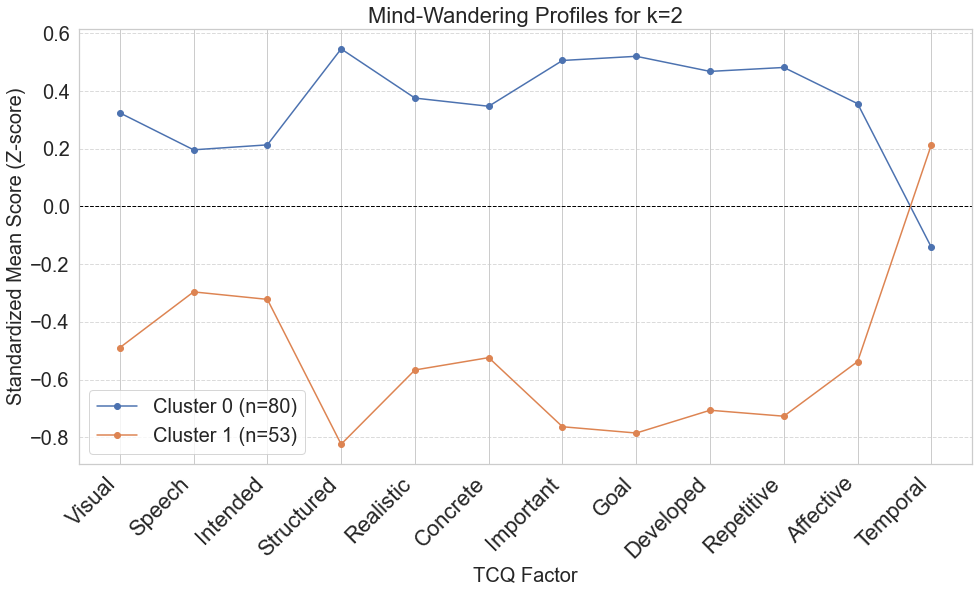

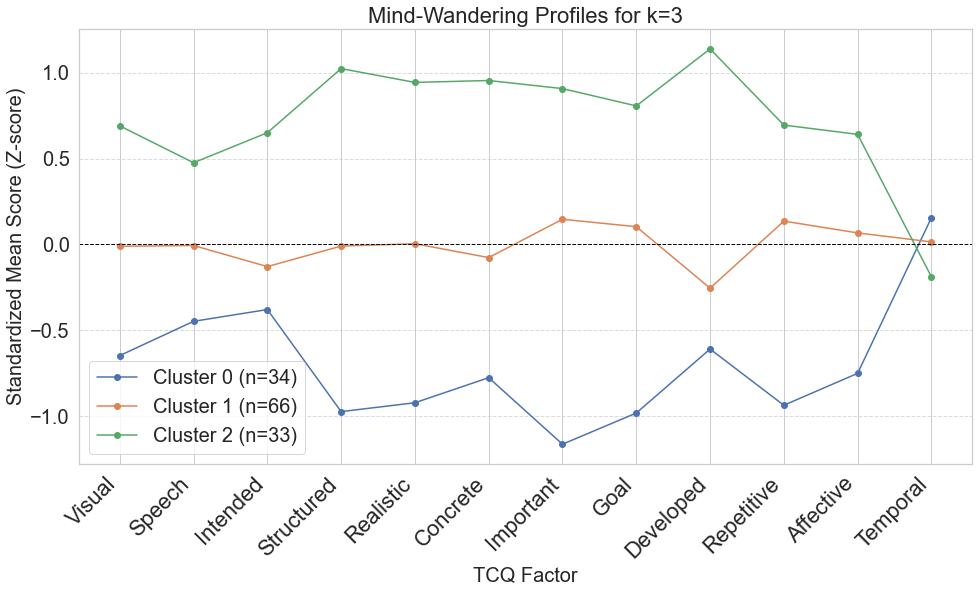

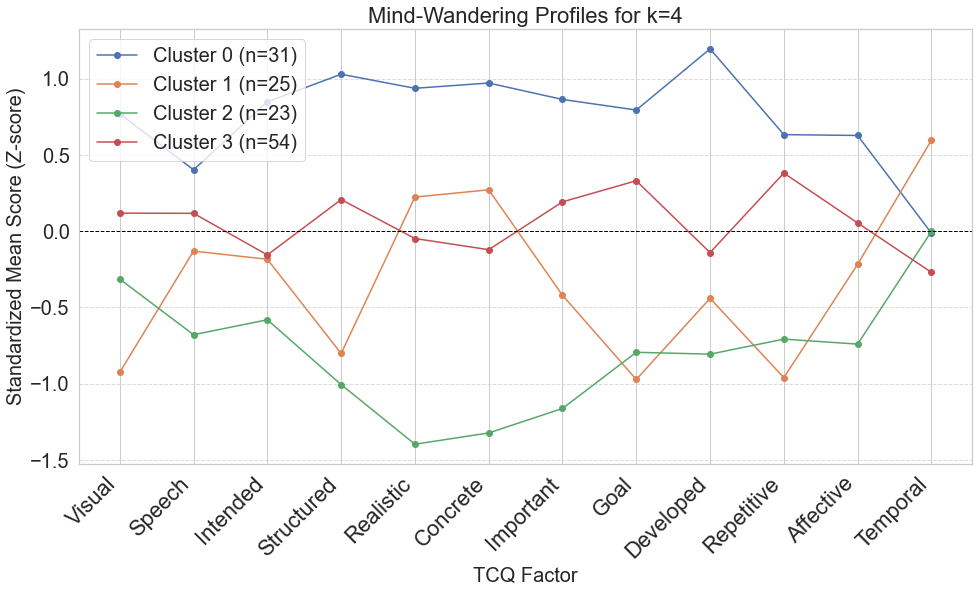

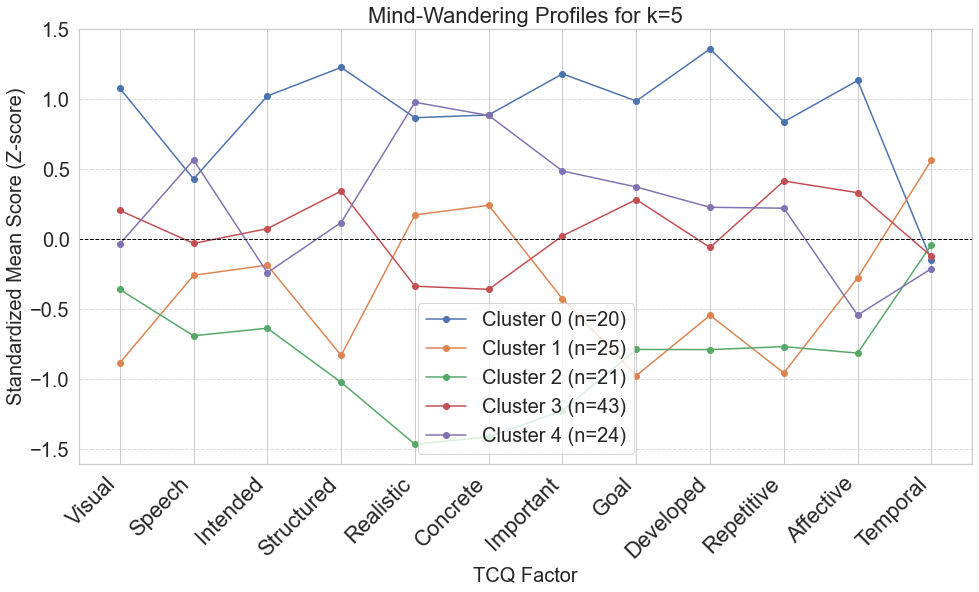

In [ ]:
# --- Loop Through Different K Values to Analyze and Visualize Clusters ---
# Based on the elbow plot, we can inspect a few promising values for k.
# Let's loop through k=2 to k=5 as an example.
analysis_k_range = range(2, 6)

for k_val in analysis_k_range:
    print(f"\n{'='*20} ANALYSIS FOR K = {k_val} {'='*20}\n")
    
    # --- Run K-Means ---
    kmeans = KMeans(n_clusters=k_val, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_df)

    # Add the cluster labels back to the original (unscaled) data
    between_clustered = cluster_data.copy()
    between_clustered['Cluster'] = cluster_labels

    # To make profiles comparable, let's view the standardized means
    scaled_cluster_profiles = scaled_df.copy()
    scaled_cluster_profiles['Cluster'] = cluster_labels
    scaled_profiles_mean = scaled_cluster_profiles.groupby('Cluster').mean()

    print(f"--- Cluster Profiles (n={k_val}) ---")
    print("The table below shows the average Z-score for each TCQ factor within each cluster.")
    display(scaled_profiles_mean.rename(columns=tcq_name_map).round(3))

    # --- Visualize the Cluster Profiles with a Snake Plot ---
    plt.figure(figsize=(16, 8))
    for i in range(k_val):
        # Get cluster size for the legend
        cluster_size = (between_clustered['Cluster'] == i).sum()
        plt.plot(scaled_profiles_mean.columns, scaled_profiles_mean.loc[i], marker='o', label=f'Cluster {i} (n={cluster_size})')

    plt.title(f'Mind-Wandering Profiles for k={k_val}', fontsize=22)
    plt.ylabel('Standardized Mean Score (Z-score)', fontsize=20)
    plt.xlabel('TCQ Factor', fontsize=20)
    plt.xticks(ticks=scaled_profiles_mean.columns, labels=scaled_profiles_mean.rename(columns=tcq_name_map).columns, rotation=45, ha='right', fontsize=22)
    plt.yticks(fontsize=20)
    plt.axhline(0, color='black', linestyle='--', lw=1) # Add a line for the overall average
    plt.legend(fontsize=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout

    #typechecl

    #typechecl
    

